# Классификация веб-атак на наборе данных SR-BH 2020
Статья: __[A new multi-label dataset for Web attacks CAPEC classification using machine learning techniques](https://www.sciencedirect.com/science/article/pii/S0167404822001833)__ <br>
Набор данных: __[SR-BH 2020 multi-label dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OGOIXX)__ 


In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

pd.set_option("display.max_columns", None)

large = 22; med = 16; small = 12
params = {'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

from scipy import stats

# Чтение исходного набора данных

In [2]:
dataset = pd.read_csv('data_capec_multilabel.csv')

C:\Users\Kolpinsky.Ser\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9,11,12,13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataset.head()

timestamp      src_ip  src_port      dst_ip  dst_port  \
0  17/Jul/2020:12:23:34 +0100  172.26.0.1   55894.0  172.26.0.4      80.0   
1  17/Jul/2020:12:23:41 +0100  172.26.0.1   55897.0  172.26.0.4      80.0   
2  17/Jul/2020:12:23:51 +0100  172.26.0.1   55901.0  172.26.0.4      80.0   
3  17/Jul/2020:12:23:51 +0100  172.26.0.1   55902.0  172.26.0.4      80.0   
4  17/Jul/2020:12:23:58 +0100  172.26.0.1   55903.0  172.26.0.4      80.0   

  request_http_method                               request_http_request  \
0                 GET                                                  /   
1                 GET  /blog/index.php/2020/04/04/voluptatum-reprehen...   
2                 GET                               /blog/xmlrpc.php?rsd   
3                 GET                                                  /   
4                 GET  /blog/index.php/2020/04/04/nihil-tenetur-et-ad...   

  request_http_protocol                                 request_user_agent  \
0              HTTP/1.1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3...   
1              HTTP/1.1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...   
2              HTTP/1.1  Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...   
3              HTTP/1.1  Mozilla/5.0 (Linux; Android 4.2.2; SM-T110 Bui...   
4              HTTP/1.1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2...   

  request_referer   request_host request_origin request_cookie  \
0             NaN  test-site.com            NaN            NaN   
1             NaN  test-site.com            NaN            NaN   
2             NaN  test-site.com            NaN            NaN   
3             NaN  test-site.com            NaN            NaN   
4             NaN  test-site.com            NaN            NaN   

  request_content_type request_accept request_accept_language  \
0                  NaN            */*                     NaN   
1                  NaN            */*                     NaN   
2                  NaN            */*                     NaN   
3                  NaN            */*                     NaN   
4                  NaN            */*                     NaN   

  request_accept_encoding  request_do_not_track request_connection  \
0           gzip, deflate                   NaN         keep-alive   
1           gzip, deflate                   NaN         keep-alive   
2           gzip, deflate                   NaN         keep-alive   
3           gzip, deflate                   NaN         keep-alive   
4           gzip, deflate                   NaN         keep-alive   

  request_body response_http_protocol  response_http_status_code  \
0          NaN               HTTP/1.1                      200.0   
1          NaN               HTTP/1.1                      200.0   
2          NaN               HTTP/1.1                      200.0   
3          NaN               HTTP/1.1                      200.0   
4          NaN               HTTP/1.1                      200.0   

  response_http_status_message  response_content_length  000 - Normal  \
0                           OK                  25174.0             1   
1                           OK                  20862.0             1   
2                           OK                    317.0             1   
3                           OK                  25174.0             1   
4                           OK                  20863.0             1   

   272 - Protocol Manipulation  242 - Code Injection  \
0                            0                     0   
1                            0                     0   
2                            0                     0   
3                            0                     0   
4                            0                     0   

   88 - OS Command Injection  126 - Path Traversal  66 - SQL Injection  \
0                          0                     0                   0   
1                          0                     0                   0   
2              

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907815 entries, 0 to 907814
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               907813 non-null  object 
 1   src_ip                                  907813 non-null  object 
 2   src_port                                907813 non-null  float64
 3   dst_ip                                  907813 non-null  object 
 4   dst_port                                907813 non-null  float64
 5   request_http_method                     907813 non-null  object 
 6   request_http_request                    907813 non-null  object 
 7   request_http_protocol                   907813 non-null  object 
 8   request_user_agent                      903981 non-null  object 
 9   request_referer                         291394 non-null  object 
 10  request_host                            9077

In [5]:
dataset.describe()

src_port  dst_port  request_do_not_track  \
count  907813.000000  907813.0                 705.0   
mean    56749.866303      80.0                   1.0   
std      5331.665110       0.0                   0.0   
min      1407.000000      80.0                   1.0   
25%     51992.000000      80.0                   1.0   
50%     55747.000000      80.0                   1.0   
75%     62110.000000      80.0                   1.0   
max     65534.000000      80.0                   1.0   

       response_http_status_code  response_content_length   000 - Normal  \
count              907813.000000            904523.000000  907815.000000   
mean                  302.851342             17999.002713       0.578526   
std                   100.599167             20200.194933       0.493795   
min                   200.000000                 0.000000       0.000000   
25%                   200.000000               276.000000       0.000000   
50%                   301.000000             21080.000000       1.000000   
75%                   404.000000             25174.000000       1.000000   
max                   501.000000            236440.000000       1.000000   

       272 - Protocol Manipulation  242 - Code Injection  \
count                907815.000000         907815.000000   
mean                      0.010082              0.017434   
std                       0.099904              0.130883   
min                       0.000000              0.000000   
25%                       0.000000              0.000000   
50%                       0.000000              0.000000   
75%                       0.000000              0.000000   
max                       1.000000              1.000000   

       88 - OS Command Injection  126 - Path Traversal  66 - SQL Injection  \
count              907815.000000         907815.000000       907815.000000   
mean                    0.008242              0.023124            0.275729   
std                     0.090409              0.150296            0.446881   
min                     0.000000              0.000000            0.000000   
25%                     0.000000              0.000000            0.000000   
50%                     0.000000              0.000000            0.000000   
75%                     0.000000              0.000000            1.000000   
max                     1.000000              1.000000            1.000000   

       16 - Dictionary-based Password Attack  \
count                          907815.000000   
mean                                0.002035   
std                                 0.045060   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.000000   
max                                 1.000000   

       310 - Scanning for Vulnerable Software  153 - Input Data Manipulation  \
count                           907815.000000                  907815.000000   
mean                                 0.002994                       0.002503   
std                                  0.054636                       0.049965   
min                                  0.000000                       0.000000   
25%                                  0.000000                       0.000000   
50%                                  0.000000                       0.000000   
75%                                  0.000000                       0.000000   
max                                  1.000000                       1.000000   

       248 - Command Injection  274 - HTTP Verb Tampering  \
count            907815.000000              907815.000000   
mean                  0.000001                   0.005989   
std                   0.001050                   0.077157   
min                   0.000000                   0.000000   
25%                   0.000000                   0.000000   
50%                   0.000000                   0.000000 

# Очистка данных

In [6]:
# убираем 2 строки с пустыми timestamp
dataset.dropna(axis=0, subset=['timestamp'], inplace=True)

# удаляем колонку, которая не описана в статье и в ней всего одна единичка
dataset.drop(['248 - Command Injection'], axis=1, inplace=True)

# заполняем нулями где пусто для корректного последующего преобразования в int
dataset['response_content_length'].fillna(0, inplace=True)
dataset['request_do_not_track'].fillna(0, inplace=True)

dataset.reset_index(drop=True, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907813 entries, 0 to 907812
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               907813 non-null  object 
 1   src_ip                                  907813 non-null  object 
 2   src_port                                907813 non-null  float64
 3   dst_ip                                  907813 non-null  object 
 4   dst_port                                907813 non-null  float64
 5   request_http_method                     907813 non-null  object 
 6   request_http_request                    907813 non-null  object 
 7   request_http_protocol                   907813 non-null  object 
 8   request_user_agent                      903981 non-null  object 
 9   request_referer                         291394 non-null  object 
 10  request_host                            9077

## Подготовка словаря с новыми типами данных

In [7]:
dataset_header = list(dataset.columns)
dataset_dtype = [object]*2 + [np.int32] + [object] + [np.int32] + [object]*12 + [np.int8] + [object]*3 + [np.int16] + [object] + [np.int32] + [np.int8]*14
dtype_dict = dict(zip(dataset_header, dataset_dtype))
dtype_dict

{'timestamp': object,
 'src_ip': object,
 'src_port': numpy.int32,
 'dst_ip': object,
 'dst_port': numpy.int32,
 'request_http_method': object,
 'request_http_request': object,
 'request_http_protocol': object,
 'request_user_agent': object,
 'request_referer': object,
 'request_host': object,
 'request_origin': object,
 'request_cookie': object,
 'request_content_type': object,
 'request_accept': object,
 'request_accept_language': object,
 'request_accept_encoding': object,
 'request_do_not_track': numpy.int8,
 'request_connection': object,
 'request_body': object,
 'response_http_protocol': object,
 'response_http_status_code': numpy.int16,
 'response_http_status_message': object,
 'response_content_length': numpy.int32,
 '000 - Normal': numpy.int8,
 '272 - Protocol Manipulation': numpy.int8,
 '242 - Code Injection': numpy.int8,
 '88 - OS Command Injection': numpy.int8,
 '126 - Path Traversal': numpy.int8,
 '66 - SQL Injection': numpy.int8,
 '16 - Dictionary-based Password Attack': 

## Обновление типов данных

In [8]:
dataset = dataset.astype(dtype_dict)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907813 entries, 0 to 907812
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   timestamp                               907813 non-null  object
 1   src_ip                                  907813 non-null  object
 2   src_port                                907813 non-null  int32 
 3   dst_ip                                  907813 non-null  object
 4   dst_port                                907813 non-null  int32 
 5   request_http_method                     907813 non-null  object
 6   request_http_request                    907813 non-null  object
 7   request_http_protocol                   907813 non-null  object
 8   request_user_agent                      903981 non-null  object
 9   request_referer                         291394 non-null  object
 10  request_host                            907781 non-null 

**Сэкономили 100 MB !**

# Оцифровывка полей запросов в средние значения ASCII-кодировки символов
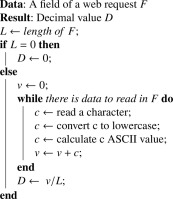

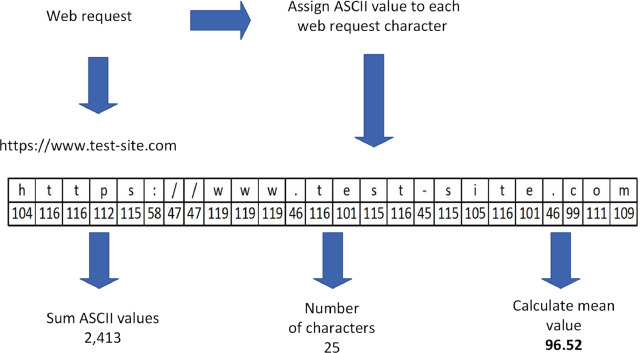

In [9]:
def mean_ascii_encoding(value):
    if type(value) != str and np.isnan(value):
        result = 0
    else:
        text = str(value).lower()
        L = len(text)
        if L==0:
            result = 0
        else:
            v = 0
            for char in text:
                v += ord(char)
            result = v / L
    
    return result

mean_ascii_encoding = np.vectorize(mean_ascii_encoding)

In [10]:
features_raw = dataset[dataset.columns[5:24]].to_numpy()
labels = dataset[dataset.columns[24:]].to_numpy()

In [11]:
%%time
features_values = mean_ascii_encoding(features_raw)

Wall time: 39.5 s


In [12]:
features_values.shape

(907813, 19)

In [13]:
labels.shape

(907813, 13)

## Собираем оцифрованные значения и метки в новый датафрейм

In [14]:
data = pd.DataFrame(data = np.concatenate((features_values, labels), axis=1),
                    columns = dataset.columns[5:])

data = data.astype(dict(zip(dataset.columns[5:], [np.float32]*19+[np.int8]*13)))
data

request_http_method  request_http_request  request_http_protocol  \
0                106.666664             47.000000                 79.875   
1                106.666664             91.519478                 79.875   
2                106.666664             97.099998                 79.875   
3                106.666664             47.000000                 79.875   
4                106.666664             85.793106                 79.875   
...                     ...                   ...                    ...   
907808           106.666664             47.000000                 79.875   
907809           106.666664             47.000000                 79.875   
907810           106.666664             47.000000                 79.875   
907811           106.666664             47.000000                 79.875   
907812           106.666664             47.000000                 79.875   

        request_user_agent  request_referer  request_host  request_origin  \
0                78.719009              0.0     99.615387             0.0   
1                77.061729              0.0     99.615387             0.0   
2                73.961784              0.0     99.615387             0.0   
3                78.132812              0.0     99.615387             0.0   
4                78.743805              0.0     99.615387             0.0   
...                    ...              ...           ...             ...   
907808           79.108330              0.0     99.615387             0.0   
907809           79.074997              0.0     99.615387             0.0   
907810           77.098763              0.0     99.615387             0.0   
907811           77.889908              0.0     99.615387             0.0   
907812           80.443550              0.0     99.615387             0.0   

        request_cookie  request_content_type  request_accept  \
0                  0.0                   0.0       43.666668   
1                  0.0                   0.0       43.666668   
2                  0.0                   0.0       43.666668   
3                  0.0                   0.0       43.666668   
4                  0.0                   0.0       43.666668   
...                ...                   ...             ...   
907808             0.0                   0.0       43.666668   
907809             0.0                   0.0       43.666668   
907810             0.0                   0.0       43.666668   
907811             0.0                   0.0       43.666668   
907812             0.0                   0.0       43.666668   

        request_accept_language  request_accept_encoding  \
0                           0.0                95.615387   
1                           0.0                95.615387   
2                           0.0                95.615387   
3                           0.0                95.615387   
4                           0.0                95.615387   
...                         ...                      ...   
907808                      0.0                95.615387   
907809                      0.0                95.615387   
907810                      0.0                95.615387   
907811                      0.0                95.615387   
907812                      0.0                95.615387   

        request_do_not_track  request_connection  request_body  \
0                       48.0                99.5           0.0   
1                       48.0                99.5           0.0   
2                       48.0                99.5           0.0   
3                       48.0                99.5           0.0   
4                       48.0                99.5           0.0   
...                      ...                 ...           ...   
907808                  48.0                99.5           0.0   
907809                  48.0                99.5           0.0   
907810                  48.0                99.5           0.0   
907811              

In [15]:
data.describe()

request_http_method  request_http_request  request_http_protocol  \
count        907813.000000         907813.000000          907813.000000   
mean            106.886024             72.786560              79.874901   
std               1.244008             19.283789               0.003546   
min             100.500000             45.000000              79.750000   
25%             106.666664             47.000000              79.875000   
50%             106.666664             79.939133              79.875000   
75%             106.666664             88.940857              79.875000   
max             115.000000            107.948715              79.875000   

       request_user_agent  request_referer   request_host  request_origin  \
count       907813.000000    907813.000000  907813.000000   907813.000000   
mean            75.299110        29.604925      99.504822        0.168773   
std              5.989327        43.126797       1.992541        4.007957   
min              0.000000         0.000000       0.000000        0.000000   
25%             73.485291         0.000000      99.615387        0.000000   
50%             73.485291         0.000000      99.615387        0.000000   
75%             77.853210        90.265060      99.615387        0.000000   
max            124.000000       124.000000      99.882355      101.181816   

       request_cookie  request_content_type  request_accept  \
count   907813.000000         907813.000000   907813.000000   
mean        43.154949              3.129560       19.044098   
std         44.133217             17.409334       22.930285   
min          0.000000              0.000000        0.000000   
25%          0.000000              0.000000        0.000000   
50%          0.000000              0.000000        0.000000   
75%         85.972725              0.000000       43.666668   
max        105.964287            124.000000      100.650002   

       request_accept_language  request_accept_encoding  request_do_not_track  \
count            907813.000000            907813.000000         907813.000000   
mean                  1.401159                38.584419             48.000774   
std                  10.508687                46.914131              0.027857   
min                   0.000000                 0.000000             48.000000   
25%                   0.000000                 0.000000             48.000000   
50%                   0.000000                 0.000000             48.000000   
75%                   0.000000                95.615387             48.000000   
max                 100.357140               110.500000             49.000000   

       request_connection   request_body  response_http_protocol  \
count       907813.000000  907813.000000           907813.000000   
mean            53.745571       2.751780               79.874962   
std             50.466885      15.810090                0.002238   
min              0.000000       0.000000               79.750000   
25%              0.000000       0.000000               79.875000   
50%             99.500000       0.000000               79.875000   
75%             99.500000       0.000000               79.875000   
max            106.800003     104.444443               79.875000   

       response_http_status_code  response_http_status_message  \
count              907813.000000                 907813.000000   
mean                   49.657303                    104.941109   
std                     0.985961                      3.952619   
min                    48.666668                     99.222221   
25%                    48.666668                    101.000000   
50%                    49.333332                    104.117645   
75%                    50.666668                    109.000000   
max                    53.000000                    109.000000   

       response_content_length   000 - Normal  272 - Protocol Manipulation  \
count            907813.000000  907813.000000        

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907813 entries, 0 to 907812
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   request_http_method                     907813 non-null  float32
 1   request_http_request                    907813 non-null  float32
 2   request_http_protocol                   907813 non-null  float32
 3   request_user_agent                      907813 non-null  float32
 4   request_referer                         907813 non-null  float32
 5   request_host                            907813 non-null  float32
 6   request_origin                          907813 non-null  float32
 7   request_cookie                          907813 non-null  float32
 8   request_content_type                    907813 non-null  float32
 9   request_accept                          907813 non-null  float32
 10  request_accept_language                 9078

In [ ]:
data.to_csv('ascii_encoded_dataset.csv', index=False)

# Разведка данных

## Распределения значений признаков в разбивке по признаку "Норма" / "Атака"

c:\users\kolpinsky.ser\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


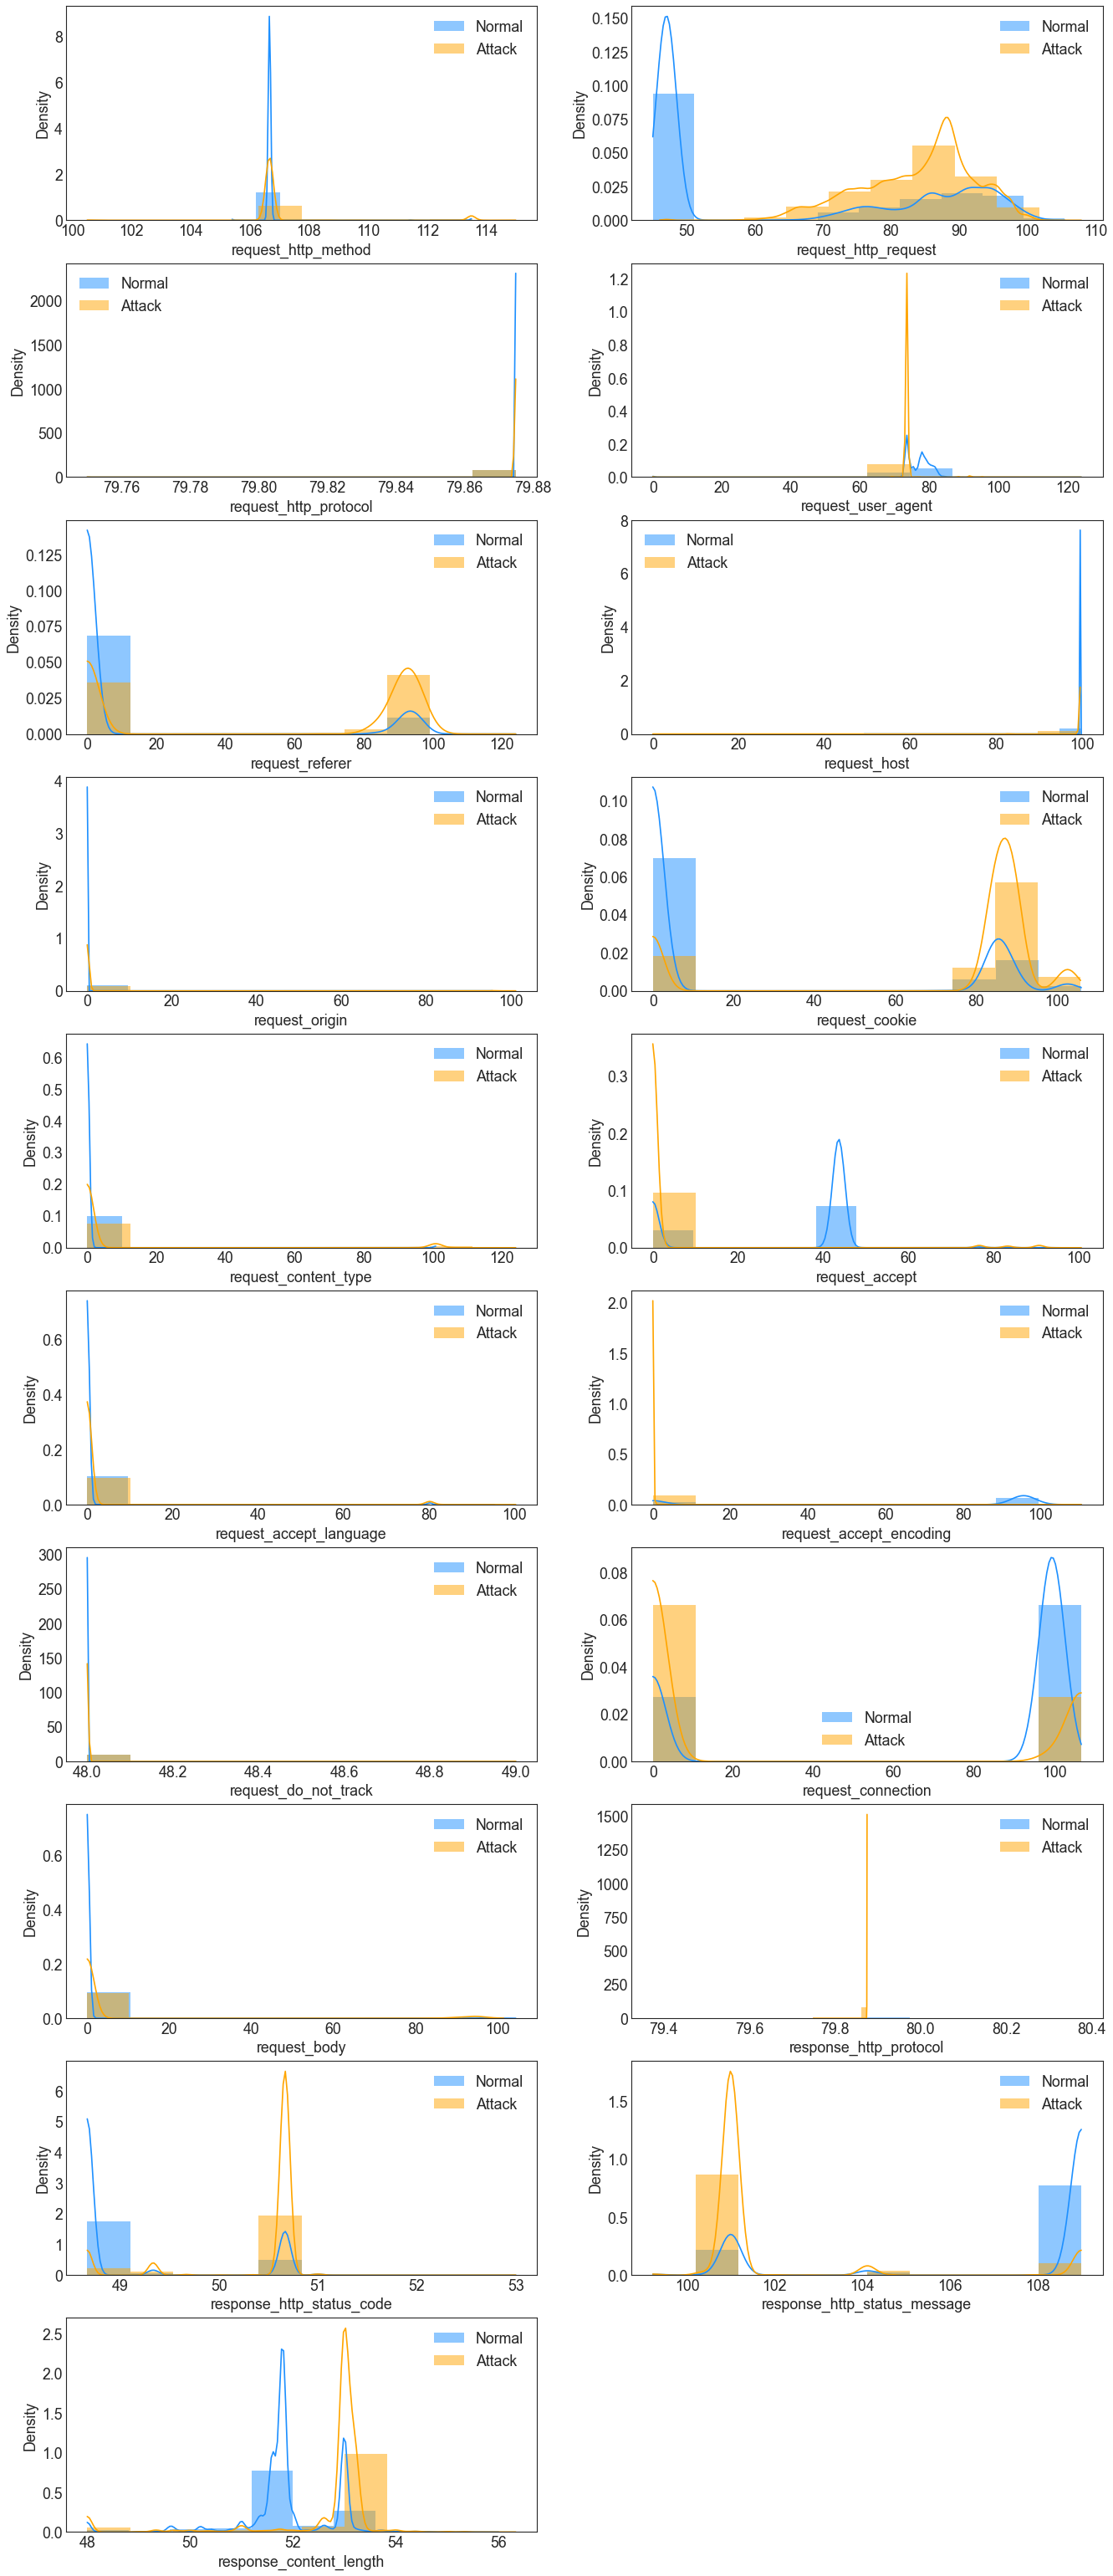

In [17]:
plt.figure(figsize=(20,50), dpi= 80)

for i, header in enumerate(data.columns[:19]):
    plt.subplot(10, 2, i+1)
    # Draw Plot
    #plt.figure(figsize=(5,4), dpi= 80)
    sns.histplot(data.loc[data['000 - Normal'] == 1, header], color="dodgerblue", bins=10, label="Normal", kde=True, stat="density", linewidth=0)
    sns.histplot(data.loc[data['000 - Normal'] == 0, header], color="orange", bins=10, label="Attack", kde=True, stat="density", linewidth=0)

    # Decoration
    #plt.title('request_http_request')
    plt.legend()



plt.savefig('1 - Исходно.png')
plt.show()

## Таблица 1. Количество веб-запросов по классификации CAPEC

In [18]:
stat = pd.DataFrame(data=np.sum(labels, axis = 0), index=data.columns[19:], columns=['Number of web requests'])
stat['% of total requests'] = stat['Number of web requests']/len(data)*100
stat

Number of web requests  \
000 - Normal                                            525193   
272 - Protocol Manipulation                               9153   
242 - Code Injection                                     15827   
88 - OS Command Injection                                 7482   
126 - Path Traversal                                     20992   
66 - SQL Injection                                      250311   
16 - Dictionary-based Password Attack                     1847   
310 - Scanning for Vulnerable Software                    2718   
153 - Input Data Manipulation                             2272   
274 - HTTP Verb Tampering                                 5437   
194 - Fake the Source of Data                            56145   
34 - HTTP Response Splitting                             19738   
33 - HTTP Request Smuggling                               1059   

                                        % of total requests  
000 - Normal                                      57.852553  
272 - Protocol Manipulation                        1.008247  
242 - Code Injection                               1.743421  
88 - OS Command Injection                          0.824179  
126 - Path Traversal                               2.312370  
66 - SQL Injection                                27.572969  
16 - Dictionary-based Password Attack              0.203456  
310 - Scanning for Vulnerable Software             0.299401  
153 - Input Data Manipulation                      0.250272  
274 - HTTP Verb Tampering                          0.598912  
194 - Fake the Source of Data                      6.184644  
34 - HTTP Response Splitting                       2.174236  
33 - HTTP Request Smuggling                        0.116654

## Таблица 2. Количество различных классификаций CAPEC, присвоенных веб-запросу

In [19]:
pd.DataFrame(np.unique(np.sum(labels, axis=1), return_counts=True), index = ['Number of different CAPEC classification',  'Number of web requests']).transpose()

Number of different CAPEC classification  Number of web requests
0                                         1                  898575
1                                         2                    8133
2                                         3                    1087
3                                         4                      18

## Таблица 3. Средние значения ASCII полей обычных и атакующих веб-запросов

In [20]:
tab3 = pd.DataFrame(data = [data[data['000 - Normal'] == 1].mean().iloc[:19], data[data['000 - Normal'] == 0].mean().iloc[:19]],
                    index=['Средние среди нормальных запросов', 'Средние среди атакующих запросов']).transpose()
tab3['Разница'] = tab3['Средние среди нормальных запросов'] != tab3['Средние среди атакующих запросов']
tab3

Средние среди нормальных запросов  \
request_http_method                                  106.718407   
request_http_request                                  64.569710   
request_http_protocol                                 79.874954   
request_user_agent                                    76.544365   
request_referer                                       13.992344   
request_host                                          99.605011   
request_origin                                         0.021485   
request_cookie                                        22.644432   
request_content_type                                   0.738267   
request_accept                                        31.115953   
request_accept_language                                0.697573   
request_accept_encoding                               66.648483   
request_do_not_track                                  48.000355   
request_connection                                    70.359039   
request_body                                           0.566191   
response_http_protocol                                79.875000   
response_http_status_code                             49.120731   
response_http_status_message                         107.125626   
response_content_length                               51.884586   

                              Средние среди атакующих запросов  Разница  
request_http_method                                 107.115868     True  
request_http_request                                 84.065201     True  
request_http_protocol                                79.874840     True  
request_user_agent                                   73.589867     True  
request_referer                                      51.035114     True  
request_host                                         99.367371     True  
request_origin                                        0.370945     True  
request_cookie                                       71.308136     True  
request_content_type                                  6.411905     True  
request_accept                                        2.473994     True  
request_accept_language                               2.366918     True  
request_accept_encoding                               0.063039     True  
request_do_not_track                                 48.001358     True  
request_connection                                   30.941551     True  
request_body                                          5.751770     True  
response_http_protocol                               79.874901     True  
response_http_status_code                            50.393917     True  
response_http_status_message                        101.942604     True  
response_content_length                              52.678123     True

## Проверка гипотез о равенстве средних по выборкам нормы и атаки
H0 - cредние равны <br> 
H1 - средние не равны


In [21]:
features_norm = data[data["000 - Normal"] == 1][data.columns[:19]].to_numpy()
features_attack = data[data["000 - Normal"] == 0][data.columns[:19]].to_numpy()

stats.ttest_ind(features_norm, features_attack, axis=0, equal_var=False)

Ttest_indResult(statistic=array([-134.59594556, -615.62939924,   13.85563405,  257.76510592,
       -424.92368703,   48.81879502,  -35.67244479, -627.25856071,
       -137.34957653,  788.48663199,  -68.89088569, 1095.55836447,
        -15.45420041,  394.3659365 , -137.71175737,   17.8036443 ,
       -817.24877745,  847.4117659 , -340.80174627]), pvalue=array([0.00000000e+000, 0.00000000e+000, 1.19699834e-043, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.80227860e-278, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       7.26331639e-054, 0.00000000e+000, 0.00000000e+000, 7.07356631e-071,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

**Результат - по всем признакам H0 отвергается. <br> Разница в средних по выборкам признается статистически значимой**

# Предобработка

## Логарифмирование 
$ \Large X_{log}=log(X)$

In [22]:
features_log = np.log(features_values)

c:\users\kolpinsky.ser\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [23]:
np.isinf(features_log).any()

True

In [24]:
features_log[features_log == -np.inf] = 0

### Распределение логарифмированных признаков

In [25]:
data_log = pd.DataFrame(data = np.concatenate((features_log, labels), axis=1),
                        columns = dataset.columns[5:])

data_log = data_log.astype(dict(zip(dataset.columns[5:], [np.float32]*19+[np.int8]*13)))

c:\users\kolpinsky.ser\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


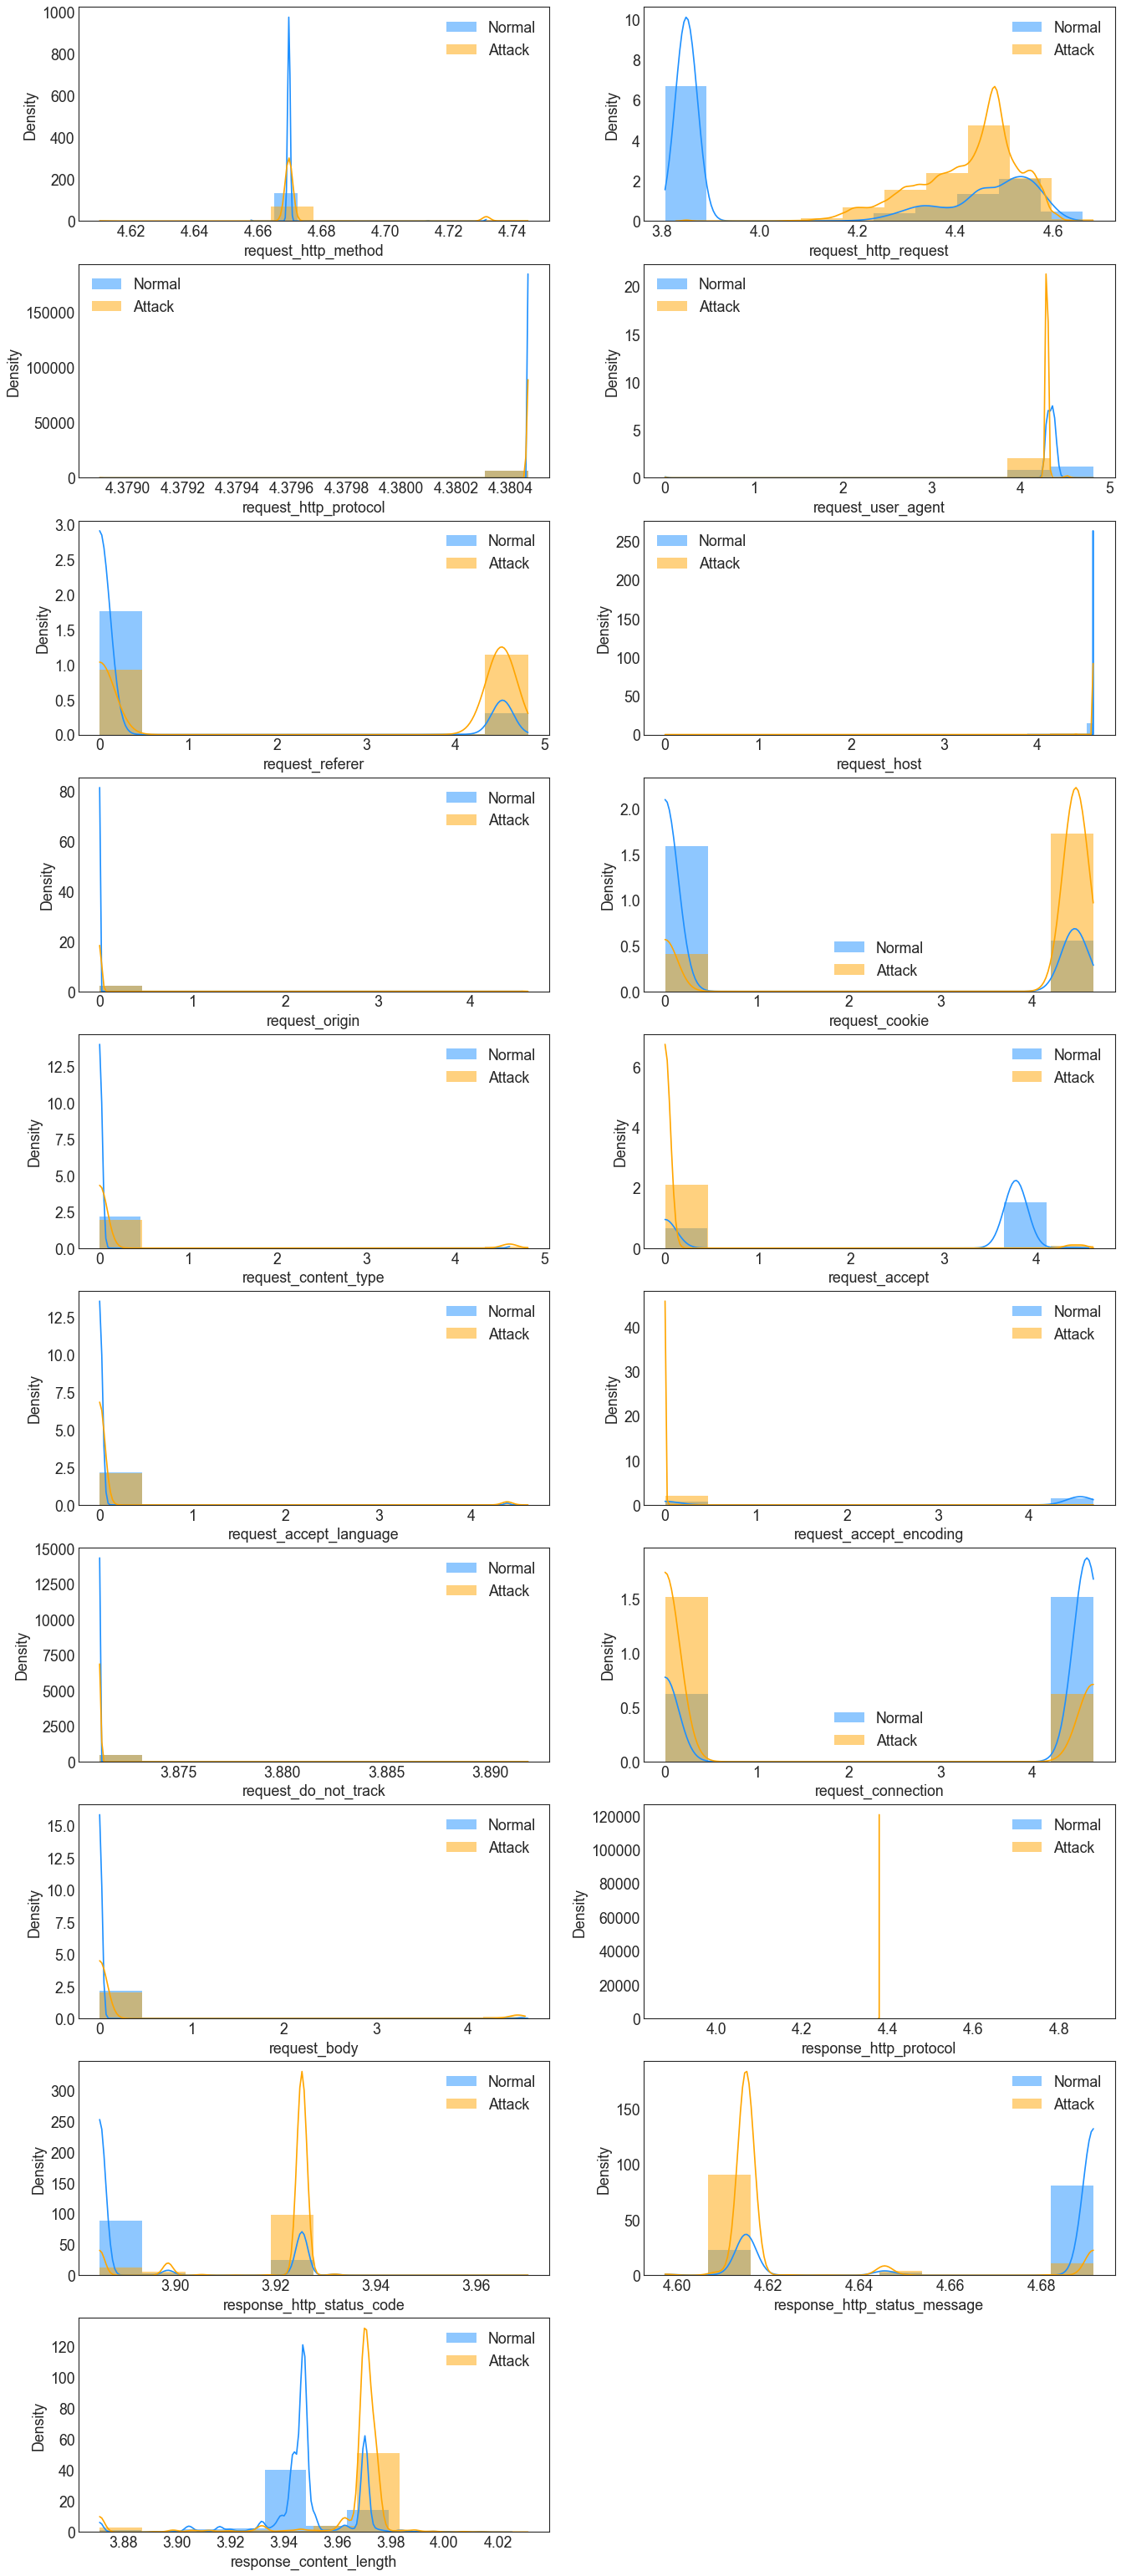

In [26]:
plt.figure(figsize=(20,50), dpi= 80)

for i, header in enumerate(data_log.columns[:19]):
    plt.subplot(10, 2, i+1)
    # Draw Plot
    #plt.figure(figsize=(5,4), dpi= 80)
    sns.histplot(data_log.loc[data_log['000 - Normal'] == 1, header], color="dodgerblue", bins=10, label="Normal", kde=True, stat="density", linewidth=0)
    sns.histplot(data_log.loc[data_log['000 - Normal'] == 0, header], color="orange", bins=10, label="Attack", kde=True, stat="density", linewidth=0)

    # Decoration
    #plt.title('request_http_request')
    plt.legend()

plt.savefig('2 - Логарифм.png')    
plt.show()

## Стандартизация <br> Но сначала train_test_split
$ \Large X_{scaled} = \frac {X - \overline X}{\sigma_{X}} $ <br>
$ \Large X_{log-scaled} = \frac {X_{log} - \overline X_{log}}{\sigma_{X_{log}}} $

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features_values, labels, test_size=.3, random_state=57)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(features_log, labels, test_size=.3, random_state=57)

In [28]:
scaler, scaler_log = StandardScaler(), StandardScaler()

scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

scaler_log.fit(X_train_log)
X_train_log_scaled, X_test_log_scaled = scaler_log.transform(X_train_log), scaler_log.transform(X_test_log)

### Распределение стандартизованных, но не логарифмированных признаков

In [29]:
data_scaled = pd.DataFrame(data = np.concatenate((np.concatenate((X_train_scaled, y_train), axis=1),
                                                  np.concatenate((X_test_scaled, y_test), axis=1)), axis=0),
                           columns = dataset.columns[5:])

data_scaled = data_scaled.astype(dict(zip(dataset.columns[5:], [np.float32]*19+[np.int8]*13)))

c:\users\kolpinsky.ser\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


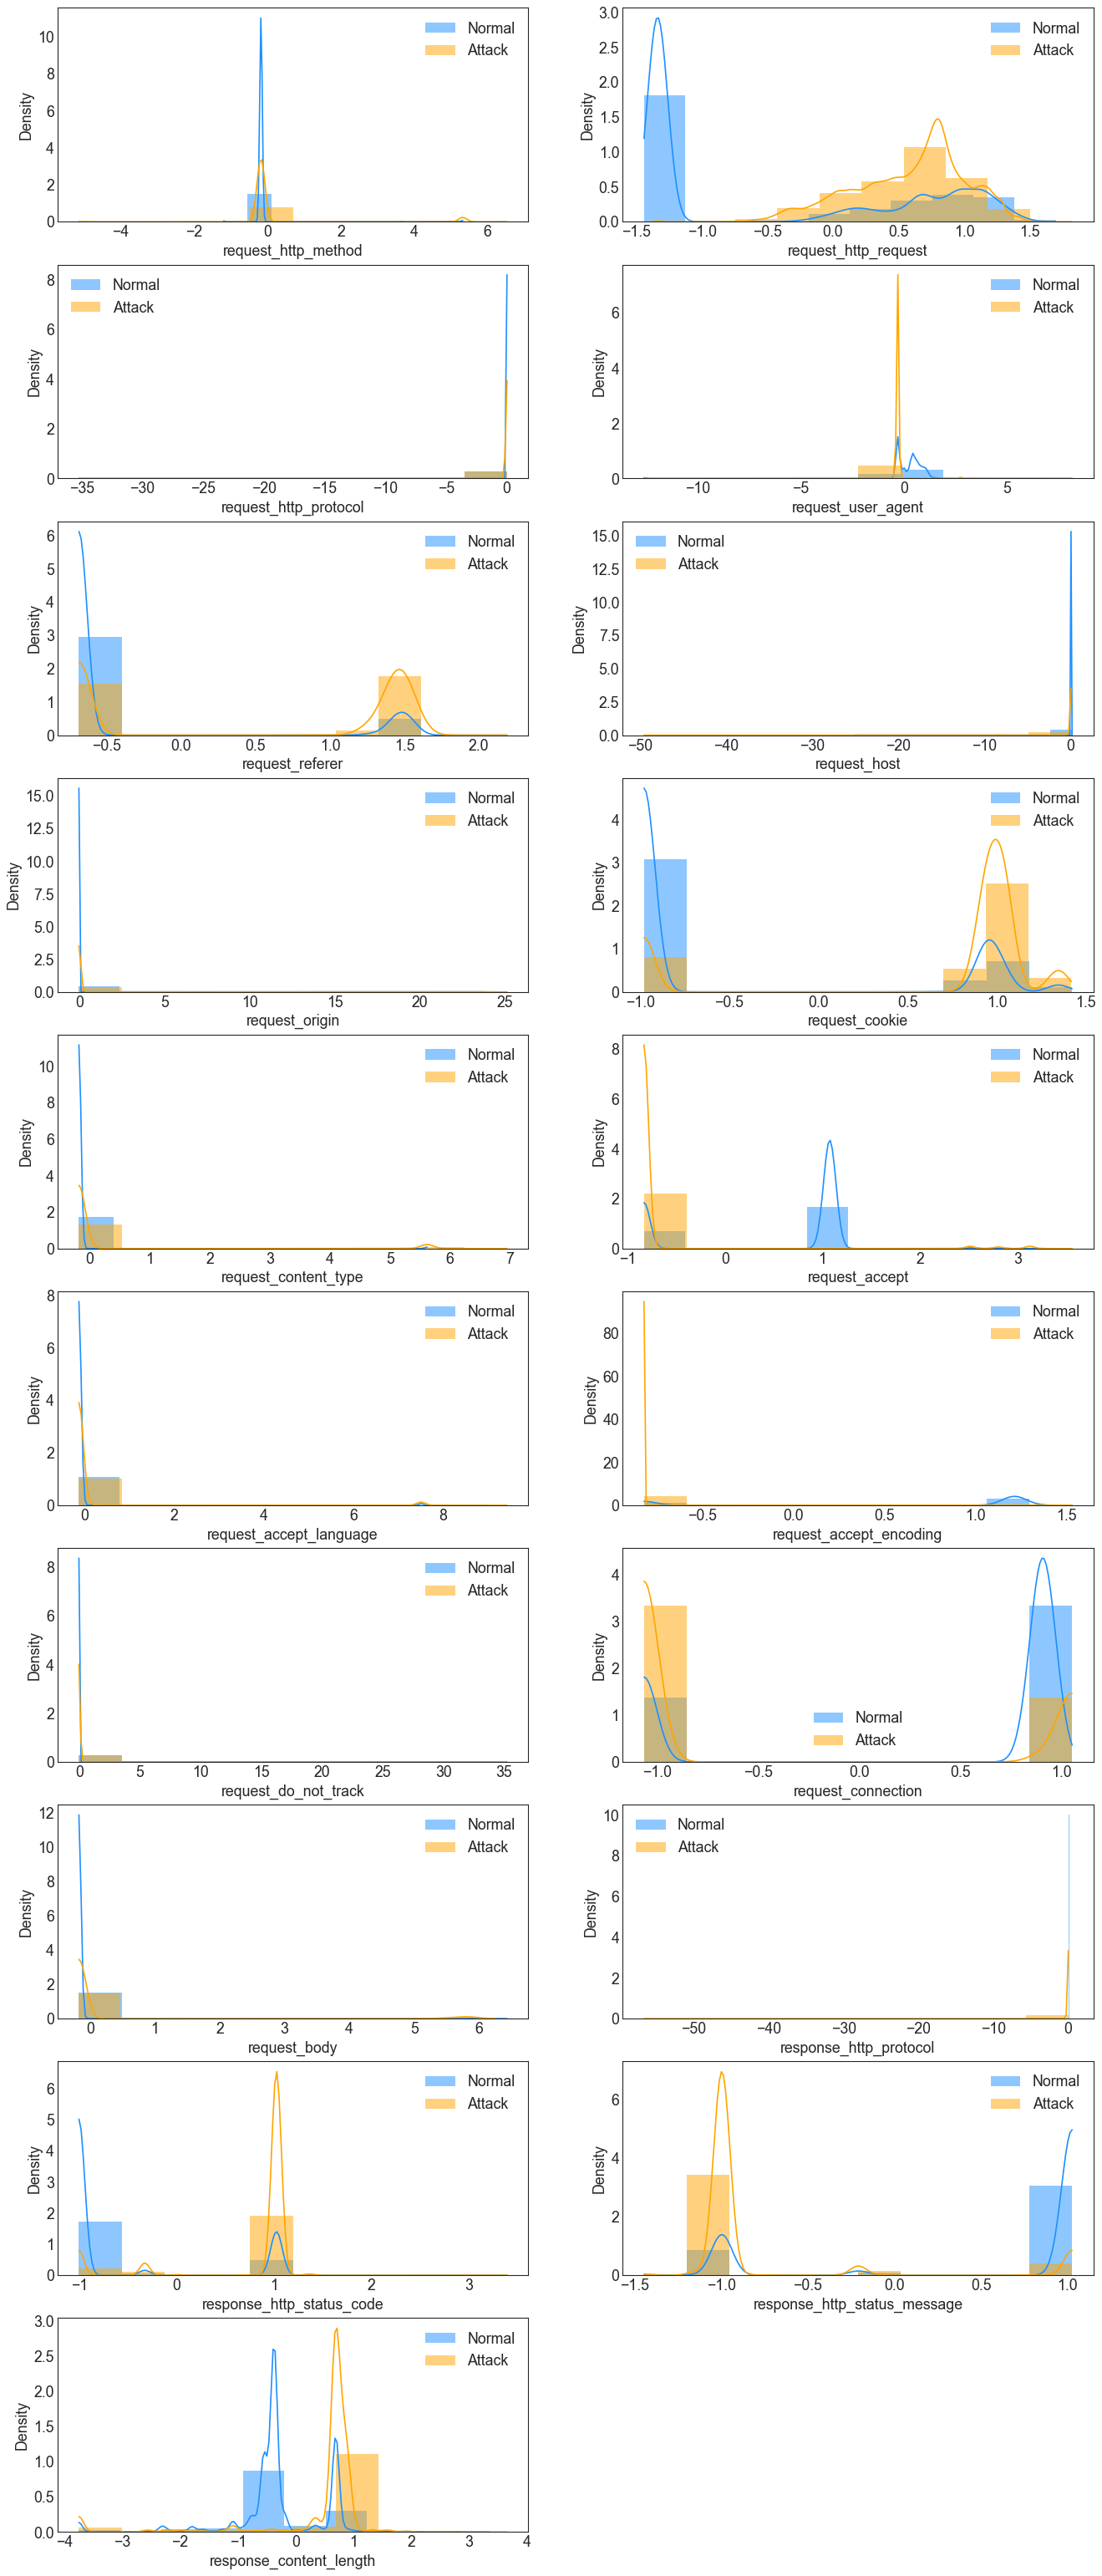

In [30]:
plt.figure(figsize=(20,50), dpi= 80)

for i, header in enumerate(data_scaled.columns[:19]):
    plt.subplot(10, 2, i+1)
    # Draw Plot
    #plt.figure(figsize=(5,4), dpi= 80)
    sns.histplot(data_scaled.loc[data_scaled['000 - Normal'] == 1, header], color="dodgerblue", bins=10, label="Normal", kde=True, stat="density", linewidth=0)
    sns.histplot(data_scaled.loc[data_scaled['000 - Normal'] == 0, header], color="orange", bins=10, label="Attack", kde=True, stat="density", linewidth=0)

    # Decoration
    #plt.title('request_http_request')
    plt.legend()

    
plt.savefig('3 - Стандартизовано.png')  
    
plt.show()

### Распределение логарифмированных стандартизованных признаков

In [31]:
data_log_scaled = pd.DataFrame(data = np.concatenate((np.concatenate((X_train_log_scaled, y_train), axis=1),
                                                      np.concatenate((X_test_log_scaled, y_test), axis=1)), axis=0),
                               columns = dataset.columns[5:])

data_log_scaled = data_log_scaled.astype(dict(zip(dataset.columns[5:], [np.float32]*19+[np.int8]*13)))

c:\users\kolpinsky.ser\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


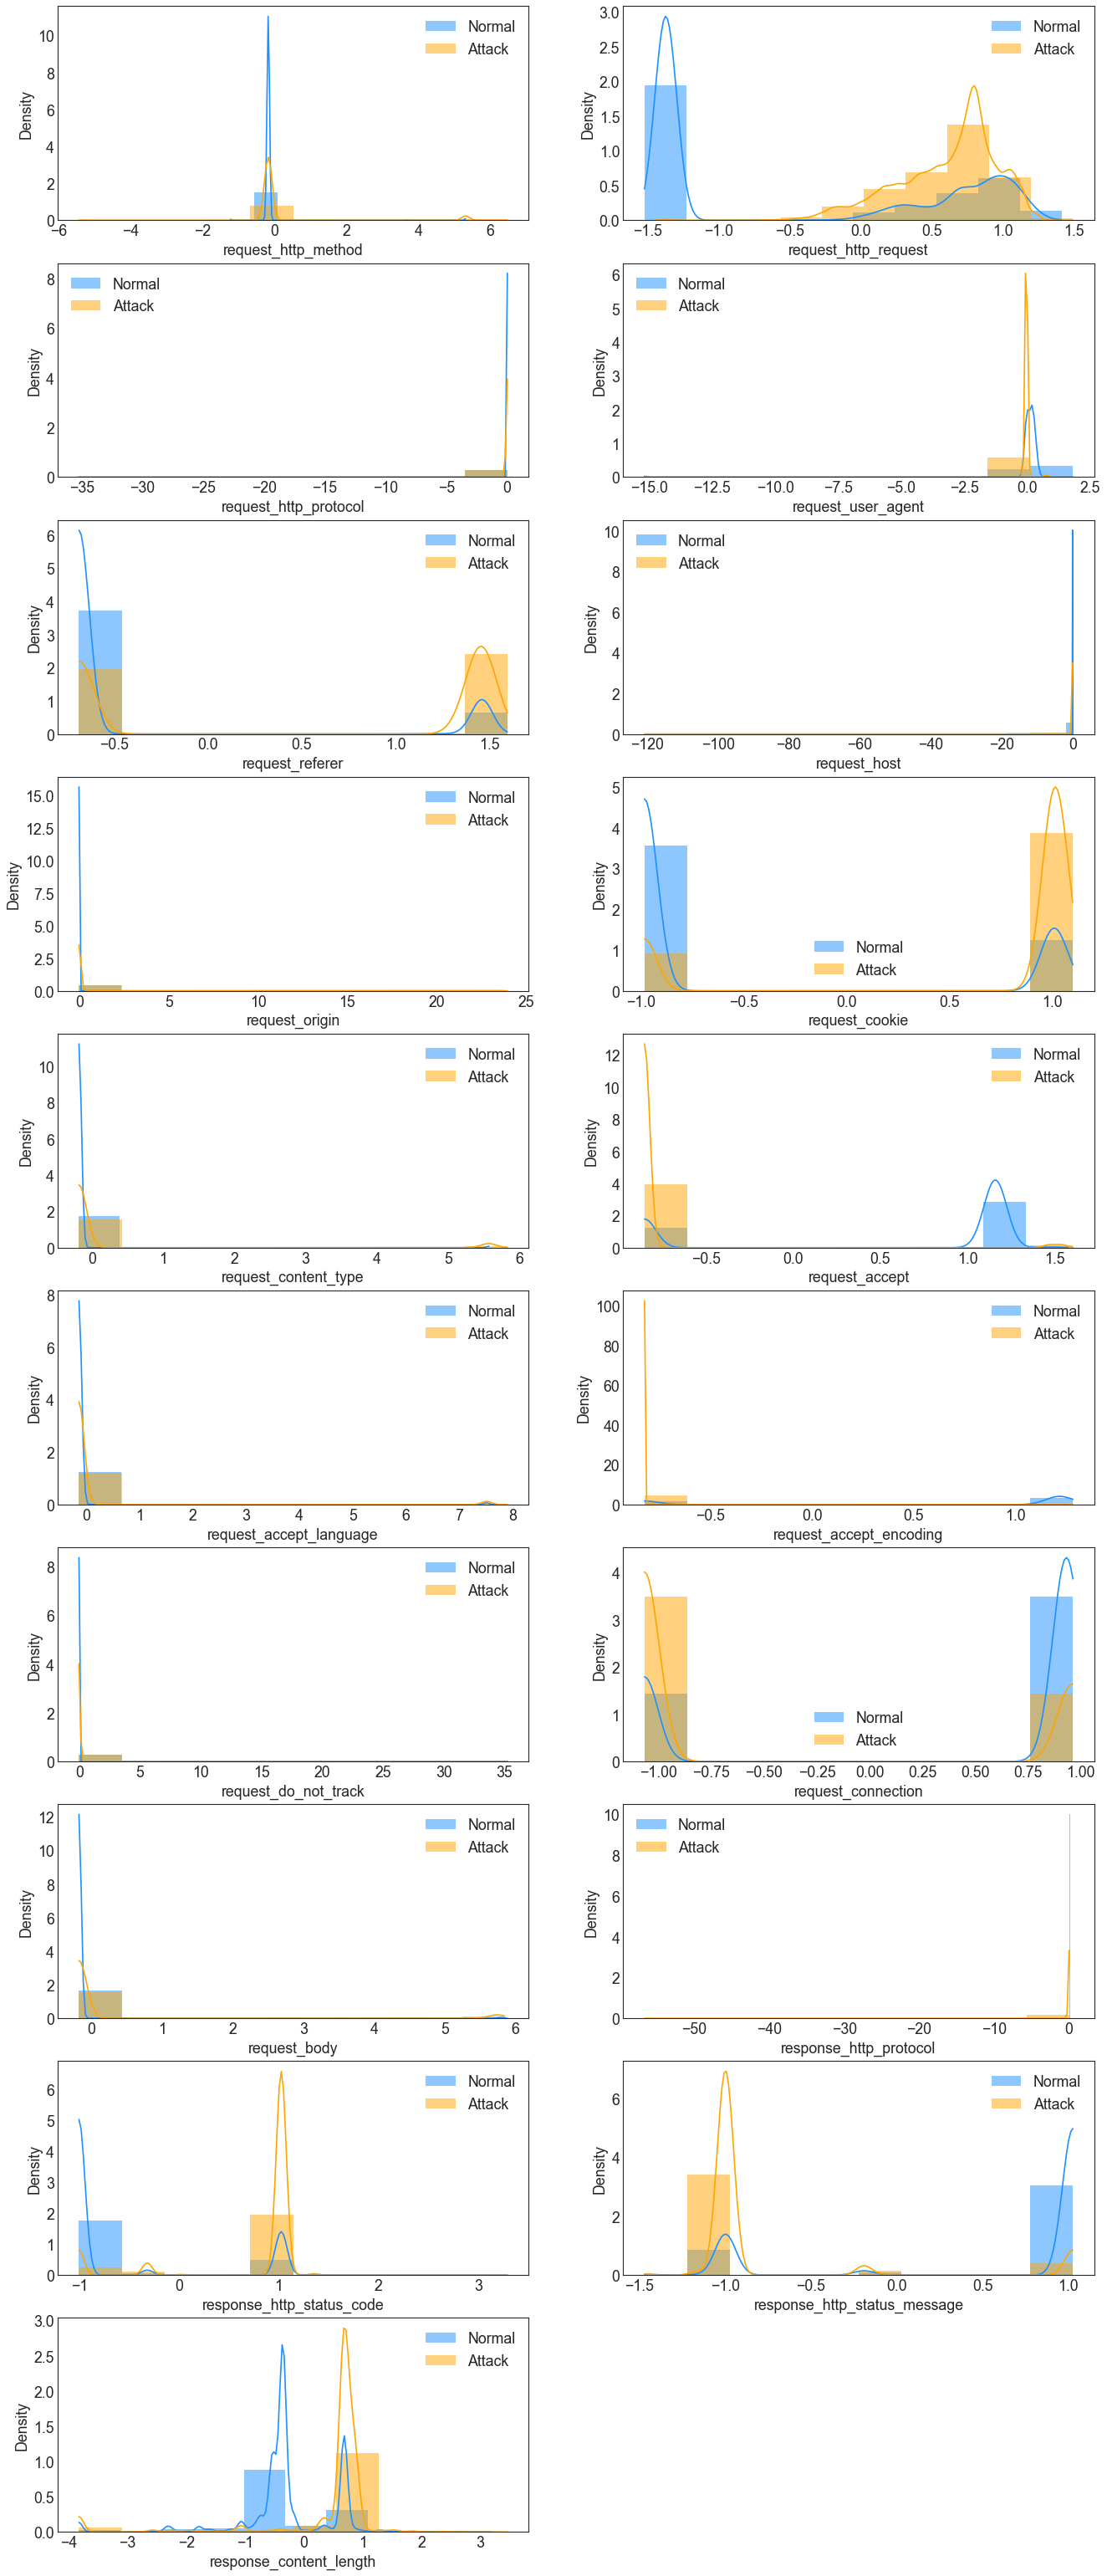

In [32]:
plt.figure(figsize=(20,50), dpi= 80)

for i, header in enumerate(data_log_scaled.columns[:19]):
    plt.subplot(10, 2, i+1)
    # Draw Plot
    #plt.figure(figsize=(5,4), dpi= 80)
    sns.histplot(data_log_scaled.loc[data_log_scaled['000 - Normal'] == 1, header], color="dodgerblue", bins=10, label="Normal", kde=True, stat="density", linewidth=0)
    sns.histplot(data_log_scaled.loc[data_log_scaled['000 - Normal'] == 0, header], color="orange", bins=10, label="Attack", kde=True, stat="density", linewidth=0)

    # Decoration
    #plt.title('request_http_request')
    plt.legend()

plt.savefig('4 - Логарифм + Стандартизовано.png')  
plt.show()

**Логарифм позволяет для некоторых признаков "раздвинуть" шляпы, а стандартизация - просто масштабирует и приводит к нулевому матожиданию и единичной дисперсии. Дальше будем использовать связку log + StandardScaler**

# Бинарная классификация на "Норму" и "Атаку"
**В качестве меток используем первый столбец labels**

In [33]:
y_train_0, y_test_0 = y_train[:,0], y_test[:,0]

Функция для перевода меток в строки

In [34]:
labeler = lambda label: 'Attack' if label == 0 else 'Normal'
labeler = np.vectorize(labeler)

y_test_0_str = labeler(y_test_0)

In [71]:
def classification_qualiy(y_true, y_pred, pos_label='Attack'):
    """ Вычисляет accuracy, recall и precision
        (последние две для класса 'Attack').
        y_true и y_pred - массивы меток 'Normal' и 'Attack' 
    """
    return [accuracy_score(y_true, y_pred),
            recall_score(y_true, y_pred, pos_label='Attack'),
            precision_score(y_true, y_pred, pos_label='Attack')]

## KNN

In [35]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_log_scaled, y_train_0)
predictions_knn = labeler(model_knn.predict(X_test_log_scaled))

In [36]:
print('KNN\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_knn),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_knn))

KNN

Confusion matrix
[[102942  12000]
 [ 13581 143821]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.88      0.90      0.89    114942
      Normal       0.92      0.91      0.92    157402

    accuracy                           0.91    272344
   macro avg       0.90      0.90      0.90    272344
weighted avg       0.91      0.91      0.91    272344



## Decision Tree

In [37]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_log_scaled, y_train_0)
predictions_dt = labeler(model_dt.predict(X_test_log_scaled))

In [38]:
print('Decision Tree\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_dt),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_dt))

Decision Tree

Confusion matrix
[[104089  10853]
 [ 10385 147017]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.91      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



## Random Forest

In [39]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_log_scaled, y_train_0)
predictions_rf = labeler(model_rf.predict(X_test_log_scaled))

In [40]:
print('Random Forest\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_rf),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_rf))

Random Forest

Confusion matrix
[[104516  10426]
 [ 10472 146930]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.91      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



## Logistic Regression

In [41]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_log_scaled, y_train_0)
predictions_lr = labeler(model_lr.predict(X_test_log_scaled))

In [42]:
print('Logistic Regression\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_lr),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_lr))

Logistic Regression

Confusion matrix
[[108692   6250]
 [ 37423 119979]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.74      0.95      0.83    114942
      Normal       0.95      0.76      0.85    157402

    accuracy                           0.84    272344
   macro avg       0.85      0.85      0.84    272344
weighted avg       0.86      0.84      0.84    272344



## SGD

In [43]:
model_sgd = SGDClassifier()
model_sgd.fit(X_train_log_scaled, y_train_0)
predictions_sgd = labeler(model_sgd.predict(X_test_log_scaled))

In [44]:
print('SGD\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_sgd),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_sgd, target_names=['Attack', 'Normal']))

SGD

Confusion matrix
[[108799   6143]
 [ 38055 119347]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.74      0.95      0.83    114942
      Normal       0.95      0.76      0.84    157402

    accuracy                           0.84    272344
   macro avg       0.85      0.85      0.84    272344
weighted avg       0.86      0.84      0.84    272344



## Сравнение алгоритмов

In [74]:
pd.DataFrame(data = {'KNN':classification_qualiy(y_test_0_str, predictions_knn),
                     'DT': classification_qualiy(y_test_0_str, predictions_dt),
                     'RF': classification_qualiy(y_test_0_str, predictions_rf),
                     'LR': classification_qualiy(y_test_0_str, predictions_lr),
                     'SGD':classification_qualiy(y_test_0_str, predictions_sgd)},
             index = ['accuracy', 'recall (Attack)', 'precision (Attack)'])

KNN        DT        RF        LR       SGD
accuracy            0.906071  0.922018  0.923266  0.839640  0.837713
recall (Attack)     0.895600  0.905578  0.909293  0.945625  0.946556
precision (Attack)  0.883448  0.909281  0.908930  0.743880  0.740865

__Random forest и Decision Tree лучшие по accuracy и precision, Logistic Regression и SGD - по recall__

## Random Forest на сырых, на логарифмированных и на стандартизованных признаках

### RF на "сырых" признаках

In [46]:
model_rf_raw = RandomForestClassifier()
model_rf_raw.fit(X_train, y_train_0)
predictions_rf_raw = labeler(model_rf_raw.predict(X_test))

In [47]:
print('Random Forest on raw data\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_rf_raw),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_rf_raw))

Random Forest on raw data

Confusion matrix
[[104565  10377]
 [ 10469 146933]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.91      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



### RF на логарифмированных признаках

In [48]:
model_rf_log = RandomForestClassifier()
model_rf_log.fit(X_train_log, y_train_0)
predictions_rf_log = labeler(model_rf_log.predict(X_test_log))

In [49]:
print('Random Forest on log data\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_rf_log),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_rf_log))

Random Forest on log data

Confusion matrix
[[104516  10426]
 [ 10504 146898]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.91      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



### RF на стандартизованных признаках

In [50]:
model_rf_scld= RandomForestClassifier()
model_rf_scld.fit(X_train_scaled, y_train_0)
predictions_rf_scld = labeler(model_rf_scld.predict(X_test_scaled))

In [51]:
print('Random Forest on scaled data\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_rf_scld),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_rf_scld))

Random Forest on scaled data

Confusion matrix
[[104569  10373]
 [ 10496 146906]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.91      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



### Сравнение

In [75]:
pd.DataFrame(data = {'raw':       classification_qualiy(y_test_0_str, predictions_rf_raw), 
                     'log':       classification_qualiy(y_test_0_str, predictions_rf_log),
                     'scaled':    classification_qualiy(y_test_0_str, predictions_rf_scld), 
                     'log_scaled':classification_qualiy(y_test_0_str, predictions_rf)},
             index = ['accuracy', 'recall (Attack)', 'precision (Attack)'])

raw       log    scaled  log_scaled
accuracy            0.923457  0.923149  0.923373    0.923266
recall (Attack)     0.909720  0.909293  0.909754    0.909293
precision (Attack)  0.908992  0.908677  0.908782    0.908930

__Существенной разницы, какие признаки подавать на Random Forest, нет__

## SGD на сырых, на логарифмированных и на стандартизованных признаках

### SGD на "сырых" признаках

In [53]:
model_sgd_raw = SGDClassifier()
model_sgd_raw.fit(X_train, y_train_0)
predictions_sgd_raw = labeler(model_sgd_raw.predict(X_test))

In [54]:
print('SGD on raw data\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_sgd_raw),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_sgd_raw))

SGD on raw data

Confusion matrix
[[ 90115  24827]
 [ 28230 129172]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.76      0.78      0.77    114942
      Normal       0.84      0.82      0.83    157402

    accuracy                           0.81    272344
   macro avg       0.80      0.80      0.80    272344
weighted avg       0.81      0.81      0.81    272344



### SGD на логарифмированных признаках

In [55]:
model_sgd_log = SGDClassifier()
model_sgd_log.fit(X_train_log, y_train_0)
predictions_sgd_log = labeler(model_sgd_log.predict(X_test_log))

In [56]:
print('SGD on log data\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_sgd_log),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_sgd_log))

SGD on log data

Confusion matrix
[[114543    399]
 [ 46370 111032]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.71      1.00      0.83    114942
      Normal       1.00      0.71      0.83    157402

    accuracy                           0.83    272344
   macro avg       0.85      0.85      0.83    272344
weighted avg       0.88      0.83      0.83    272344



### SGD на стандартизованных признаках

In [57]:
model_sgd_scld= SGDClassifier()
model_sgd_scld.fit(X_train_scaled, y_train_0)
predictions_sgd_scld = labeler(model_sgd_scld.predict(X_test_scaled))

In [58]:
print('SGD on scaled data\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_sgd_scld),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_sgd_scld))

SGD on scaled data

Confusion matrix
[[108785   6157]
 [ 38064 119338]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.74      0.95      0.83    114942
      Normal       0.95      0.76      0.84    157402

    accuracy                           0.84    272344
   macro avg       0.85      0.85      0.84    272344
weighted avg       0.86      0.84      0.84    272344



### Сравнение

In [76]:
pd.DataFrame(data = {'raw':       classification_qualiy(y_test_0_str, predictions_sgd_raw), 
                     'log':       classification_qualiy(y_test_0_str, predictions_sgd_log),
                     'scaled':    classification_qualiy(y_test_0_str, predictions_sgd_scld), 
                     'log_scaled':classification_qualiy(y_test_0_str, predictions_sgd)},
             index = ['accuracy', 'recall (Attack)', 'precision (Attack)'])

raw       log    scaled  log_scaled
accuracy            0.805184  0.828272  0.837628    0.837713
recall (Attack)     0.784004  0.996529  0.946434    0.946556
precision (Attack)  0.761460  0.711832  0.740795    0.740865

__В целом лучше масштабировать, но просто логарифм дает хороший recall__

# Отбор признаков

## Классификация с использованием избранных признаков из статьи

In [60]:
selected_features_article = ['request_http_method', 'request_http_request', 'request_referer', 'request_user_agent', 'request_cookie',
                             'request_accept', 'request_body', 'response_http_status_message', 'response_content_length']
sel_feat_art_idx = [data.columns.get_loc(feature_name) for feature_name in selected_features_article]
sel_feat_art_idx

[0, 1, 4, 3, 7, 9, 14, 17, 18]

In [61]:
X_train_sel = X_train[:, sel_feat_art_idx]
X_test_sel = X_test[:, sel_feat_art_idx]

X_train_log_sel = X_train_log[:, sel_feat_art_idx]
X_test_log_sel = X_test_log[:, sel_feat_art_idx]

X_train_scaled_sel = X_train_scaled[:, sel_feat_art_idx]
X_test_scaled_sel = X_test_scaled[:, sel_feat_art_idx]

X_train_log_scaled_sel = X_train_log_scaled[:, sel_feat_art_idx]
X_test_log_scaled_sel = X_test_log_scaled[:, sel_feat_art_idx]

### Random Forest

In [62]:
model_rf_sel = RandomForestClassifier()
model_rf_sel.fit(X_train_log_scaled_sel, y_train_0)
predictions_rf_sel = labeler(model_rf_sel.predict(X_test_log_scaled_sel))

In [63]:
print('Random Forest on selected features from article\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_rf_sel),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_rf_sel))

Random Forest on selected features from article

Confusion matrix
[[104559  10383]
 [ 11449 145953]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.90      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



### SGD

In [64]:
model_sgd_sel = SGDClassifier()
model_sgd_sel.fit(X_train_log_scaled_sel, y_train_0)
predictions_sgd_sel = labeler(model_sgd_sel.predict(X_test_log_scaled_sel))

In [65]:
print('SGD on selected features from article\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_sgd_sel),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_sgd_sel))

SGD on selected features from article

Confusion matrix
[[108423   6519]
 [ 37996 119406]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.74      0.94      0.83    114942
      Normal       0.95      0.76      0.84    157402

    accuracy                           0.84    272344
   macro avg       0.84      0.85      0.84    272344
weighted avg       0.86      0.84      0.84    272344



__Лучше не стало__

## Рекурсивное отбрасывание признаков

In [177]:
## Отбор по accuracy 
model_rf_rfecv = RandomForestClassifier()
rfecv = RFECV(estimator=model_rf_rfecv,
             step=1,
             cv=StratifiedKFold(5),
             scoring='accuracy',
             min_features_to_select=1)

# для отбора по recall или precision делать так:
# scoring=make_scorer(recall_score, pos_label=0),

In [178]:
rfecv.fit(X_train_log_scaled, y_train_0)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='accuracy')

In [179]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 14


In [180]:
pd.DataFrame(rfecv.support_, index=data.columns[:19], columns=['Support'])

Support
request_http_method              True
request_http_request             True
request_http_protocol           False
request_user_agent               True
request_referer                  True
request_host                     True
request_origin                  False
request_cookie                   True
request_content_type             True
request_accept                   True
request_accept_language         False
request_accept_encoding          True
request_do_not_track            False
request_connection               True
request_body                     True
response_http_protocol          False
response_http_status_code        True
response_http_status_message     True
response_content_length          True

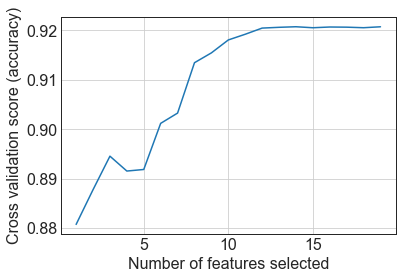

In [181]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.grid_scores_) + 1),
    rfecv.grid_scores_,
)
plt.grid()
plt.show()

In [182]:
rfecv.support_

array([ True,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
        True])

In [183]:
sel_feat_rfecv_idx = [n for n, i in enumerate(rfecv.support_) if i]
sel_feat_rfecv_idx

[0, 1, 3, 4, 5, 7, 8, 9, 11, 13, 14, 16, 17, 18]

In [184]:
X_train_log_scaled_sel_rfecv = X_train_log_scaled[:, sel_feat_rfecv_idx]
X_test_log_scaled_sel_rfecv = X_test_log_scaled[:, sel_feat_rfecv_idx]

### Random Forest

In [185]:
model_rf_sel_rfecv = RandomForestClassifier()
model_rf_sel_rfecv.fit(X_train_log_scaled_sel_rfecv, y_train_0)
predictions_rf_sel_rfecv = labeler(model_rf_sel_rfecv.predict(X_test_log_scaled_sel_rfecv))

In [186]:
print('Random Forest on features selected by RFECV \n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_rf_sel_rfecv),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_rf_sel_rfecv))

Random Forest on features selected by RFECV 

Confusion matrix
[[104550  10392]
 [ 10486 146916]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.91      0.91      0.91    114942
      Normal       0.93      0.93      0.93    157402

    accuracy                           0.92    272344
   macro avg       0.92      0.92      0.92    272344
weighted avg       0.92      0.92      0.92    272344



### SGD

In [187]:
model_sgd_sel_rfecv = SGDClassifier()
model_sgd_sel_rfecv.fit(X_train_log_scaled_sel_rfecv, y_train_0)
predictions_sgd_sel_rfecv = labeler(model_sgd_sel_rfecv.predict(X_test_log_scaled_sel_rfecv))

In [188]:
print('SGD on on features selected by RFECV\n')
print('Confusion matrix')
print(confusion_matrix(y_test_0_str, predictions_sgd_sel_rfecv),'\n')
print('Classification report')
print(classification_report(y_test_0_str, predictions_sgd_sel_rfecv))

SGD on on features selected by RFECV

Confusion matrix
[[108778   6164]
 [ 38030 119372]] 

Classification report
              precision    recall  f1-score   support

      Attack       0.74      0.95      0.83    114942
      Normal       0.95      0.76      0.84    157402

    accuracy                           0.84    272344
   macro avg       0.85      0.85      0.84    272344
weighted avg       0.86      0.84      0.84    272344



## Сравнение

In [189]:
pd.DataFrame(data = {'Article + RF':  classification_qualiy(y_test_0_str, predictions_rf_sel), 
                     'Article + SGD': classification_qualiy(y_test_0_str, predictions_sgd_sel),
                     'RFECV + RF':    classification_qualiy(y_test_0_str, predictions_rf_sel_rfecv), 
                     'RFECV + SGD':   classification_qualiy(y_test_0_str, predictions_sgd_sel_rfecv)},
             index = ['accuracy', 'recall (Attack)', 'precision (Attack)'])

Article + RF  Article + SGD  RFECV + RF  RFECV + SGD
accuracy                0.919837       0.836549    0.923340     0.837727
recall (Attack)         0.909667       0.943284    0.909589     0.946373
precision (Attack)      0.901309       0.740498    0.908846     0.740954

# Полное сравнение

In [192]:
comparsion = pd.DataFrame(data = {'KNN':        classification_qualiy(y_test_0_str, predictions_knn),
                                  'DT':         classification_qualiy(y_test_0_str, predictions_dt),
                                  'LR':         classification_qualiy(y_test_0_str, predictions_lr),
                                  'RF':         classification_qualiy(y_test_0_str, predictions_rf),
                                  'RF raw':     classification_qualiy(y_test_0_str, predictions_rf_raw), 
                                  'RF log':     classification_qualiy(y_test_0_str, predictions_rf_log),
                                  'RF scaled':  classification_qualiy(y_test_0_str, predictions_rf_scld), 
                                  'SGD':        classification_qualiy(y_test_0_str, predictions_sgd),
                                  'SGD raw':    classification_qualiy(y_test_0_str, predictions_sgd_raw), 
                                  'SGD log':    classification_qualiy(y_test_0_str, predictions_sgd_log),
                                  'SGD scaled': classification_qualiy(y_test_0_str, predictions_sgd_scld), 
                                  'Article selected + RF':  classification_qualiy(y_test_0_str, predictions_rf_sel), 
                                  'Article selectrd + SGD': classification_qualiy(y_test_0_str, predictions_sgd_sel),
                                  'RFECV + RF': classification_qualiy(y_test_0_str, predictions_rf_sel_rfecv), 
                                  'RFECV + SGD':classification_qualiy(y_test_0_str, predictions_sgd_sel_rfecv)},
                          index = ['accuracy', 'recall (Attack)', 'precision (Attack)']).transpose()
comparsion

accuracy  recall (Attack)  precision (Attack)
KNN                     0.906071         0.895600            0.883448
DT                      0.922018         0.905578            0.909281
LR                      0.839640         0.945625            0.743880
RF                      0.923266         0.909293            0.908930
RF raw                  0.923457         0.909720            0.908992
RF log                  0.923149         0.909293            0.908677
RF scaled               0.923373         0.909754            0.908782
SGD                     0.837713         0.946556            0.740865
SGD raw                 0.805184         0.784004            0.761460
SGD log                 0.828272         0.996529            0.711832
SGD scaled              0.837628         0.946434            0.740795
Article selected + RF   0.919837         0.909667            0.901309
Article selectrd + SGD  0.836549         0.943284            0.740498
RFECV + RF              0.923340         0.909589            0.908846
RFECV + SGD             0.837727         0.946373            0.740954

In [210]:
comparsion.sort_values(by='accuracy', inplace=True)

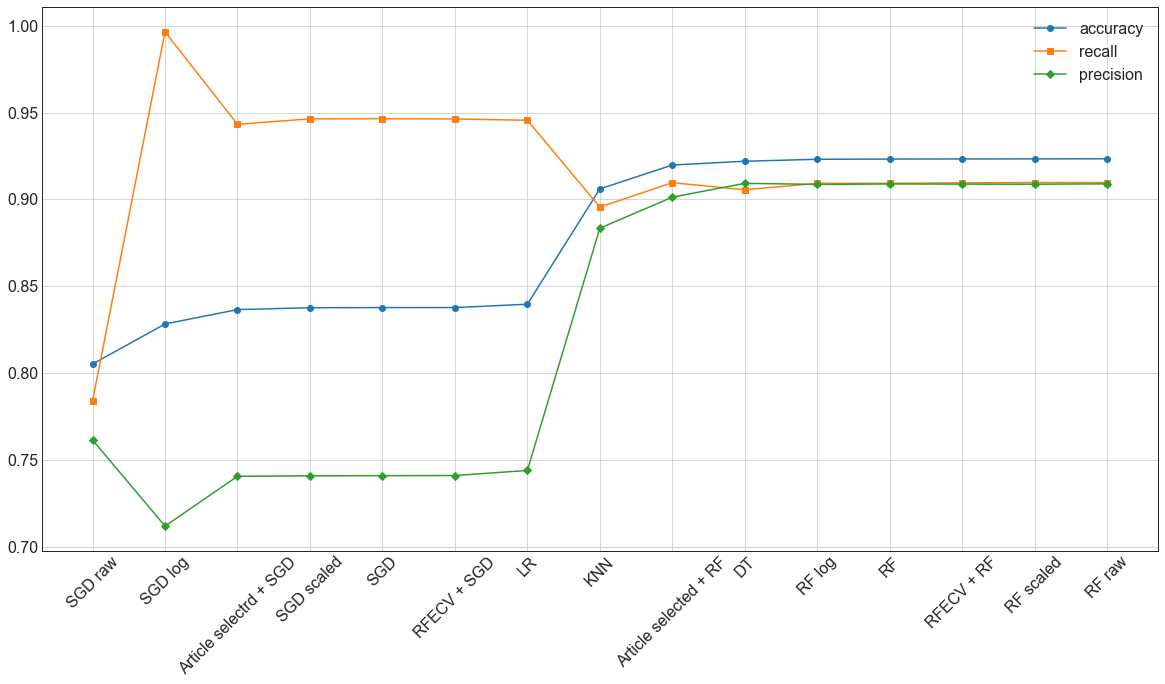

In [215]:
plt.figure(figsize=(20, 10))
plt.plot(comparsion.index, comparsion['accuracy'], marker='o', label = 'accuracy')
plt.plot(comparsion.index, comparsion['recall (Attack)'], marker='s', label = 'recall')
plt.plot(comparsion.index, comparsion['precision (Attack)'], marker='D', label = 'precision')
plt.legend()
plt.grid()
plt.xticks(rotation = 45);

# Визуализация при помощи t-SNE

## Perplexity=30

In [228]:
X_for_tsne = np.concatenate((X_train_log_scaled,X_test_log_scaled))
y_for_tsne = np.concatenate((y_train, y_test))

In [230]:
tsne = TSNE(init='pca', random_state=57, verbose=2, perplexity=30.0)

In [231]:
%%time
tsne.fit(X_for_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 907813 samples in 0.022s...
[t-SNE] Computed neighbors for 907813 samples in 14813.581s...
[t-SNE] Computed conditional probabilities for sample 1000 / 907813
[t-SNE] Computed conditional probabilities for sample 2000 / 907813
[t-SNE] Computed conditional probabilities for sample 3000 / 907813
[t-SNE] Computed conditional probabilities for sample 4000 / 907813
[t-SNE] Computed conditional probabilities for sample 5000 / 907813
[t-SNE] Computed conditional probabilities for sample 6000 / 907813
[t-SNE] Computed conditional probabilities for sample 7000 / 907813
[t-SNE] Computed conditional probabilities for sample 8000 / 907813
[t-SNE] Computed conditional probabilities for sample 9000 / 907813
[t-SNE] Computed conditional probabilities for sample 10000 / 907813
[t-SNE] Computed conditional probabilities for sample 11000 / 907813
[t-SNE] Computed conditional probabilities for sample 12000 / 907813
[t-SNE] Computed conditional pro

TSNE(init='pca', random_state=57, verbose=2)

In [239]:
tsne_df = pd.DataFrame(data=np.column_stack((tsne.embedding_, y_for_tsne[:,0])),
                      columns=['f0','f1','label'])

In [240]:
tsne_df

f0         f1  label
0       14.454598  15.262248    0.0
1       -8.037604  -6.510781    1.0
2        0.081129  13.481487    0.0
3       16.316559   2.455867    0.0
4        5.977543 -10.838478    1.0
...           ...        ...    ...
907808   4.556373  -8.708082    0.0
907809  16.899515  -5.640773    0.0
907810  -2.232618 -17.121706    0.0
907811   1.597064  12.664406    0.0
907812   7.079244  16.077972    1.0

[907813 rows x 3 columns]

In [263]:
tsne_df['multilabel'] = np.argmax(y_for_tsne, axis=1)

In [313]:
tsne_df.to_csv('tsne_embedding.csv', index=False)

C:\Users\Kolpinsky.Ser\AppData\Roaming\Python\Python36\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


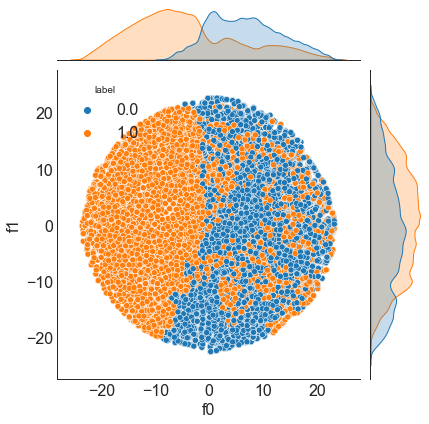

In [364]:
sns.jointplot(x='f0', y='f1', hue='label', data=tsne_df)

In [355]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
        'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rebeccapurple', 'tomato', 'magenta']

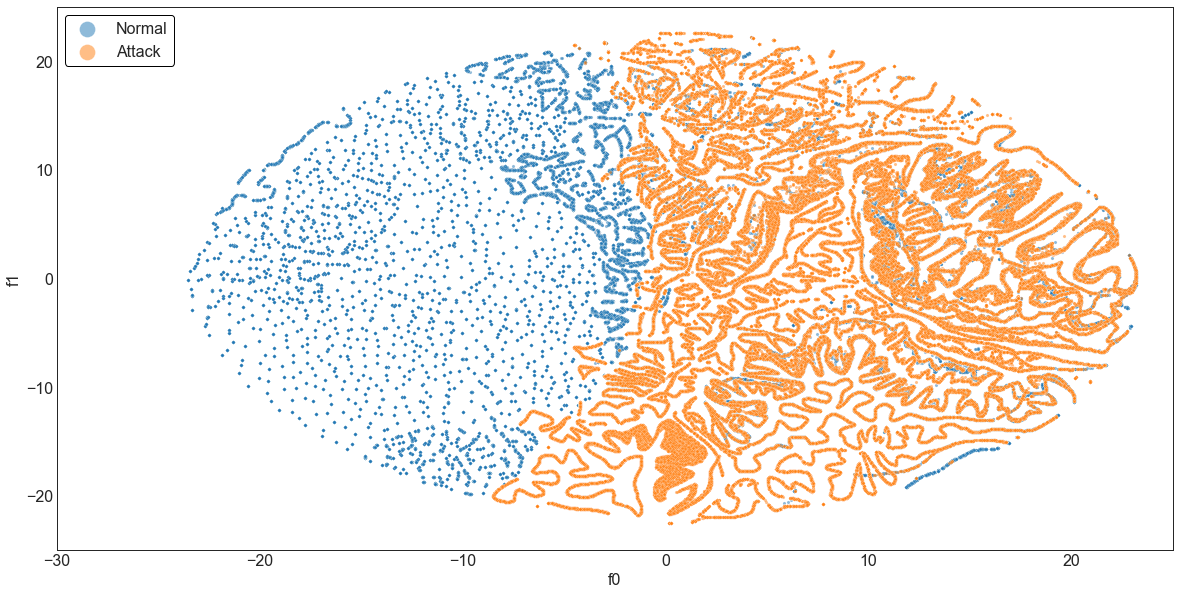

In [356]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='f0', y='f1', data=tsne_df[tsne_df['label']==1], alpha=0.5, s=10, label='Normal', color = colors[0])
sns.scatterplot(x='f0', y='f1', data=tsne_df[tsne_df['label']==0], alpha=0.5, s=10, label='Attack', color = colors[1])
plt.xlim([-30,25])
plt.ylim([-25,25])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.show()

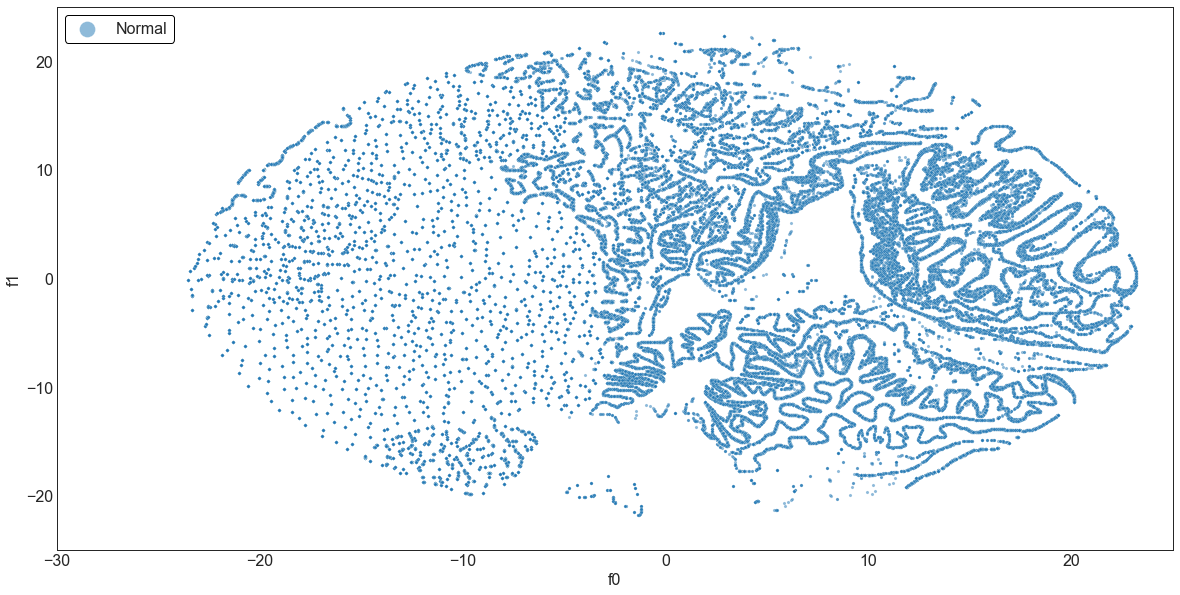

In [357]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='f0', y='f1', data=tsne_df[tsne_df['label']==1], alpha=0.5, s=10, label='Normal', color = colors[0])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.xlim([-30,25])
plt.ylim([-25,25])
plt.show()

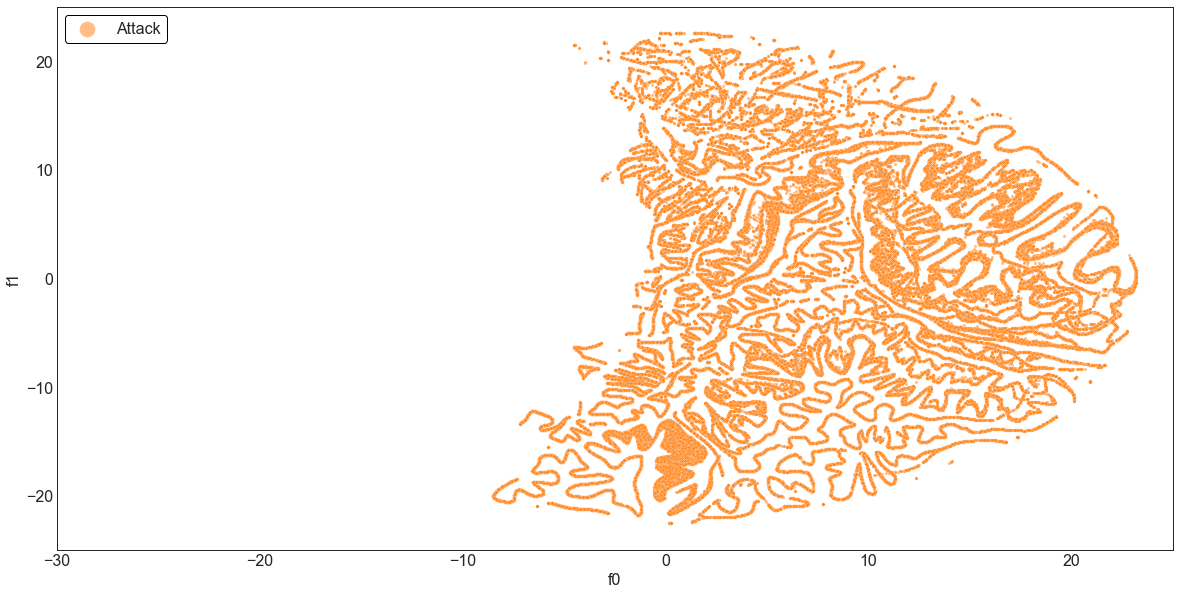

In [358]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='f0', y='f1', data=tsne_df[tsne_df['label']==0], alpha=0.5, s=10, label='Attack', color = colors[1])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.xlim([-30,25])
plt.ylim([-25,25])
plt.show()

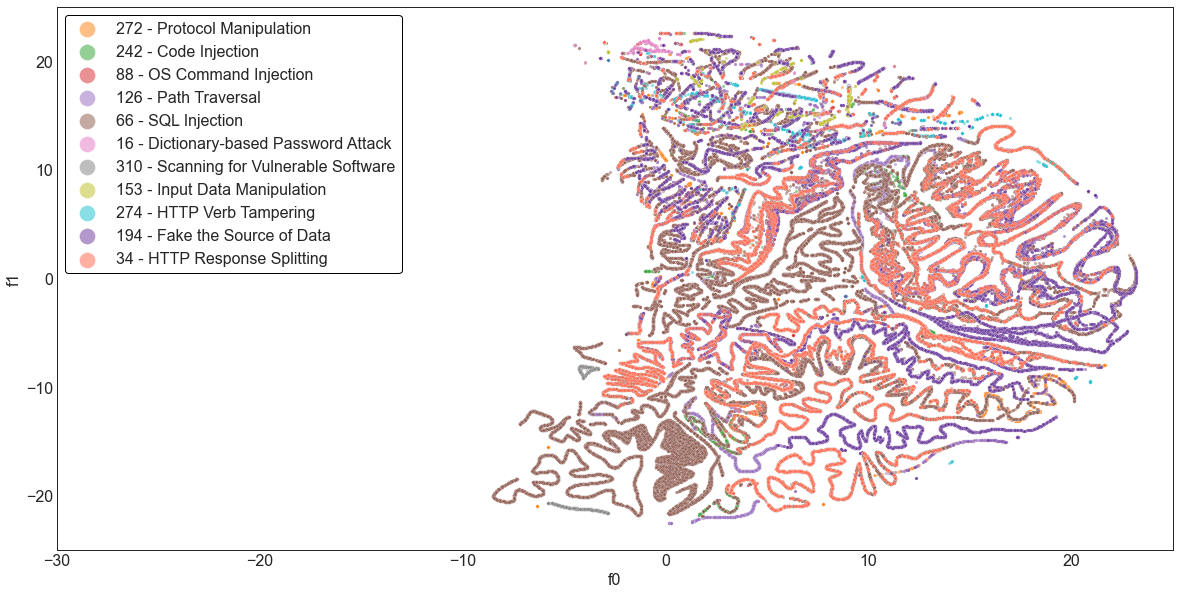

In [361]:
plt.figure(figsize=(20, 10))
for i in range(1,13):
    sns.scatterplot(x='f0', y='f1', data=tsne_df[tsne_df['multilabel']==i], alpha=0.5, s=10, label=data.columns[19:][i], color = colors[i])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.xlim([-30,25])
plt.ylim([-25,25])
plt.show()

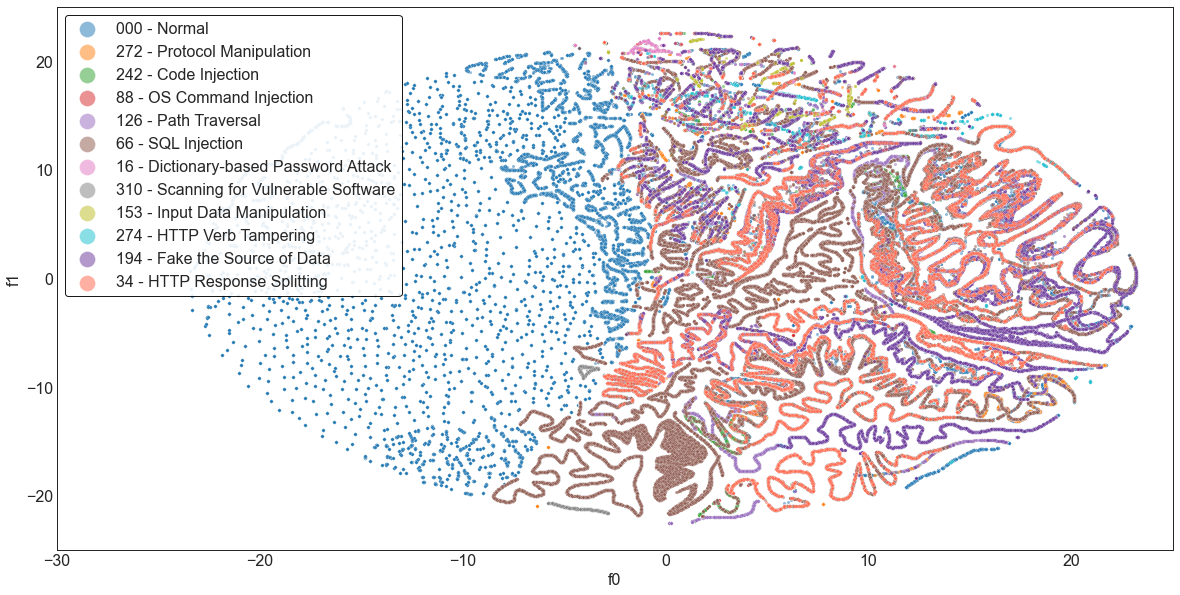

In [359]:
plt.figure(figsize=(20, 10))
for i in range(13):
    sns.scatterplot(x='f0', y='f1', data=tsne_df[tsne_df['multilabel']==i], alpha=0.5, s=10, label=data.columns[19:][i], color = colors[i])

plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=0.9)
plt.xlim([-30,25])
plt.ylim([-25,25])
plt.show()

## N_iter = 500 (вместо 1000)

In [379]:
tsne2 = TSNE(init='pca', random_state=75, verbose=2, perplexity=30, n_iter=500)

In [380]:
%%time
tsne2.fit(X_for_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 907813 samples in 0.022s...
[t-SNE] Computed neighbors for 907813 samples in 15344.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 907813
[t-SNE] Computed conditional probabilities for sample 2000 / 907813
[t-SNE] Computed conditional probabilities for sample 3000 / 907813
[t-SNE] Computed conditional probabilities for sample 4000 / 907813
[t-SNE] Computed conditional probabilities for sample 5000 / 907813
[t-SNE] Computed conditional probabilities for sample 6000 / 907813
[t-SNE] Computed conditional probabilities for sample 7000 / 907813
[t-SNE] Computed conditional probabilities for sample 8000 / 907813
[t-SNE] Computed conditional probabilities for sample 9000 / 907813
[t-SNE] Computed conditional probabilities for sample 10000 / 907813
[t-SNE] Computed conditional probabilities for sample 11000 / 907813
[t-SNE] Computed conditional probabilities for sample 12000 / 907813
[t-SNE] Computed conditional pro

TSNE(init='pca', n_iter=500, perplexity=30, random_state=75, verbose=2)

In [381]:
tsne2_df = pd.DataFrame(data=np.column_stack((tsne2.embedding_, y_for_tsne[:,0])),
                        columns=['f0','f1','label'])

In [382]:
tsne2_df

f0        f1  label
0       4.810620  5.336221    0.0
1      -2.695700 -1.944081    1.0
2       0.058914  4.209899    0.0
3       6.904552  0.705212    0.0
4       2.428796 -3.660398    1.0
...          ...       ...    ...
907808  2.258646 -3.126095    0.0
907809  7.274723 -2.105335    0.0
907810 -0.588485 -5.567635    0.0
907811  0.632508  4.062278    0.0
907812  3.034276  5.264552    1.0

[907813 rows x 3 columns]

In [383]:
tsne2_df['multilabel'] = np.argmax(y_for_tsne, axis=1)

In [384]:
tsne2_df.to_csv('tsne2_embedding.csv', index=False)

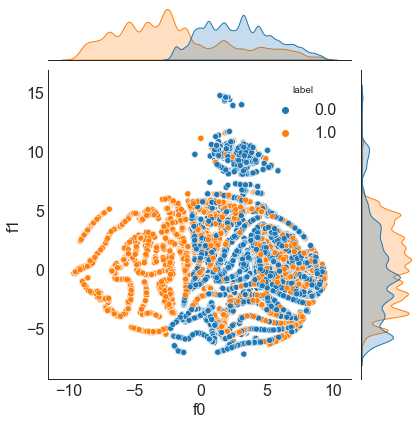

In [385]:
sns.jointplot(x='f0', y='f1', hue='label', data=tsne2_df)

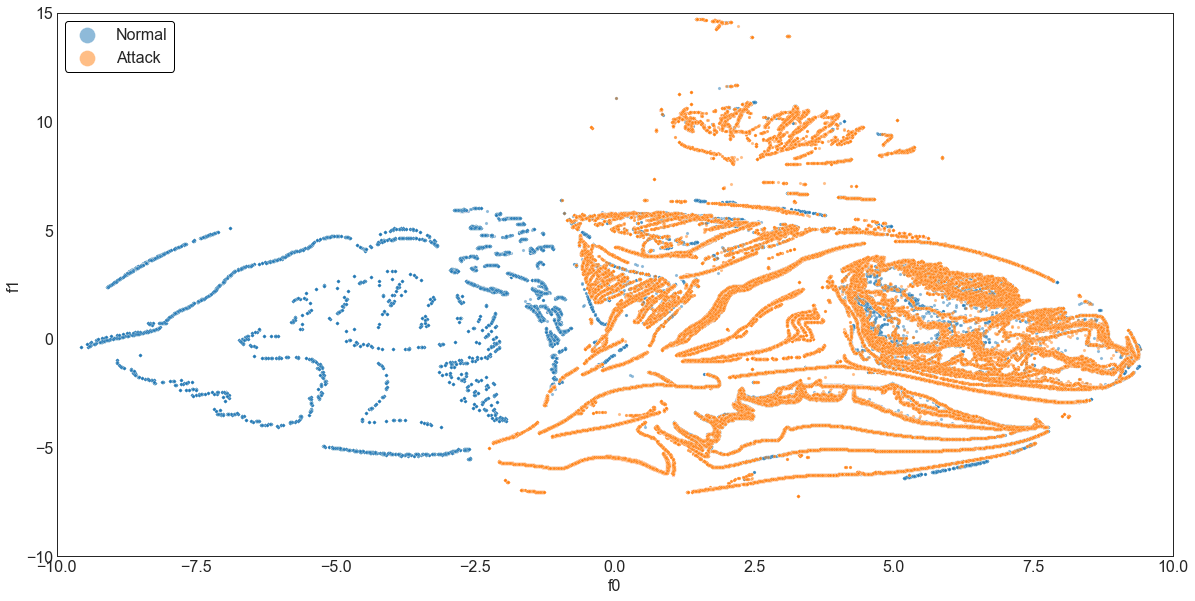

In [396]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='f0', y='f1', data=tsne2_df[tsne2_df['label']==1], alpha=0.5, s=10, label='Normal', color = colors[0])
sns.scatterplot(x='f0', y='f1', data=tsne2_df[tsne2_df['label']==0], alpha=0.5, s=10, label='Attack', color = colors[1])
plt.xlim([-10,10])
plt.ylim([-10,15])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.show()

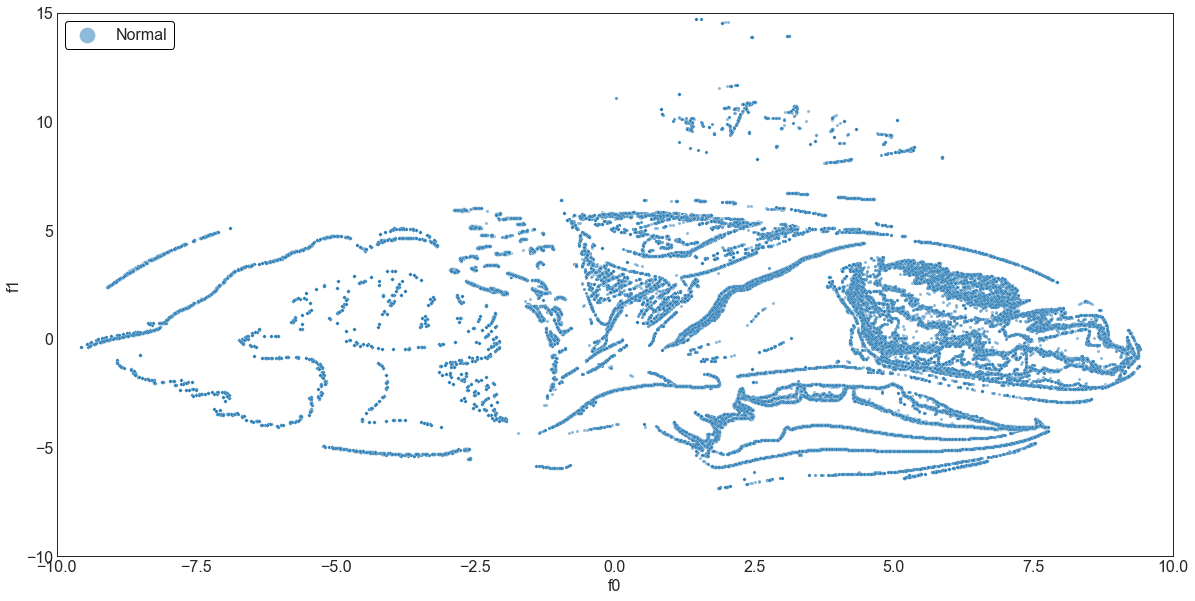

In [393]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='f0', y='f1', data=tsne2_df[tsne2_df['label']==1], alpha=0.5, s=10, label='Normal', color = colors[0])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.xlim([-10,10])
plt.ylim([-10,15])
plt.show()

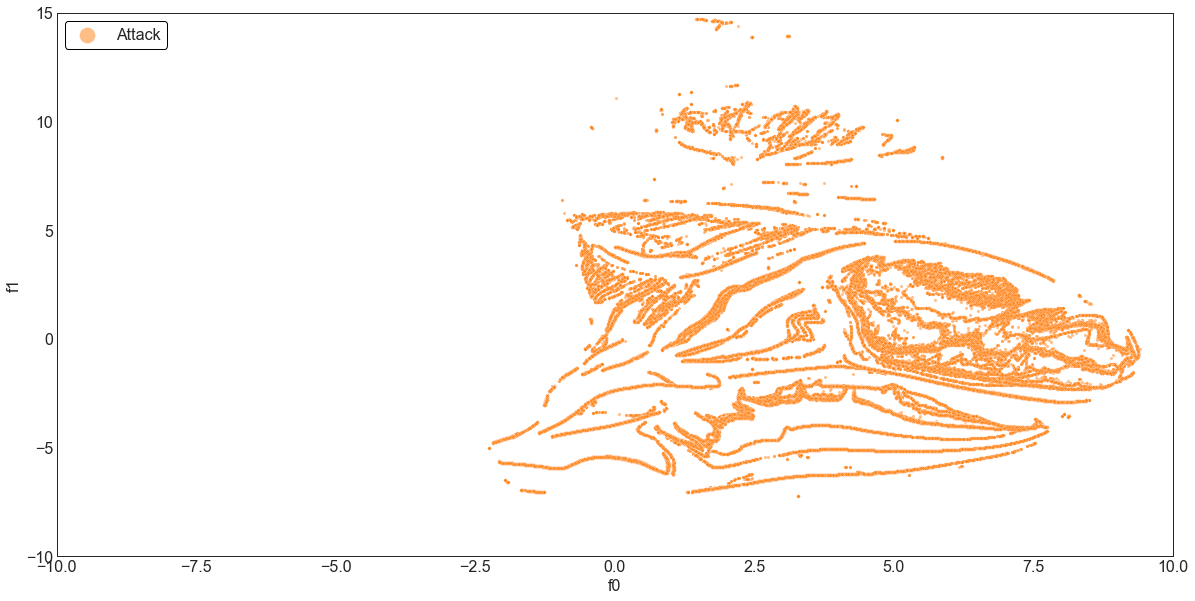

In [394]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='f0', y='f1', data=tsne2_df[tsne2_df['label']==0], alpha=0.5, s=10, label='Attack', color = colors[1])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.xlim([-10,10])
plt.ylim([-10,15])
plt.show()

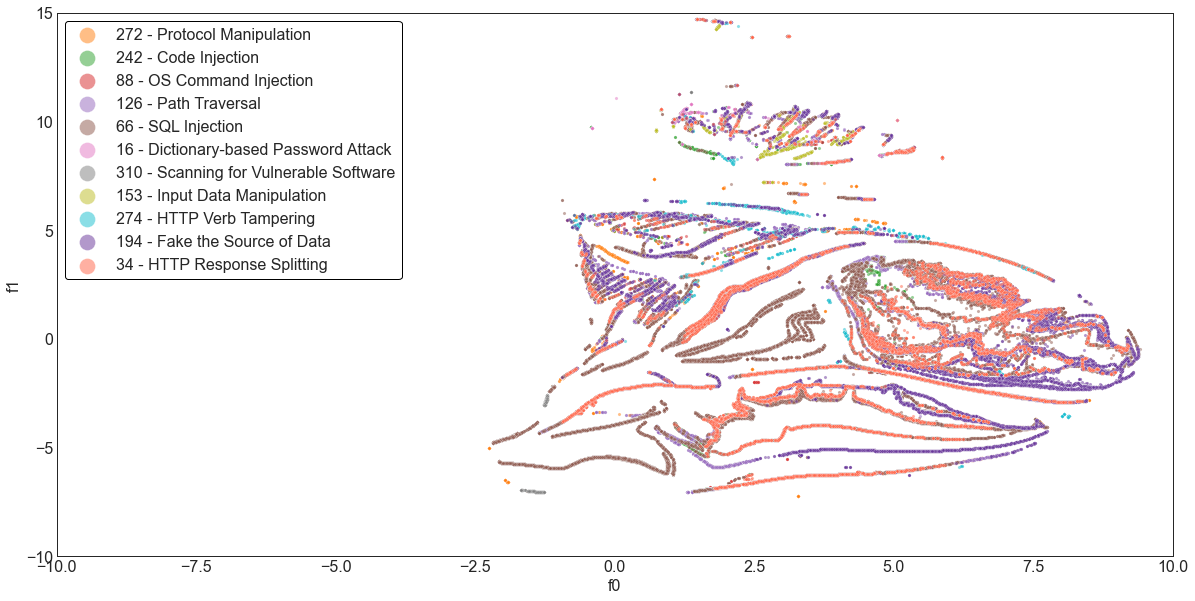

In [395]:
plt.figure(figsize=(20, 10))
for i in range(1,13):
    sns.scatterplot(x='f0', y='f1', data=tsne2_df[tsne2_df['multilabel']==i], alpha=0.5, s=10, label=data.columns[19:][i], color = colors[i])
plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=1)
plt.xlim([-10,10])
plt.ylim([-10,15])
plt.show()

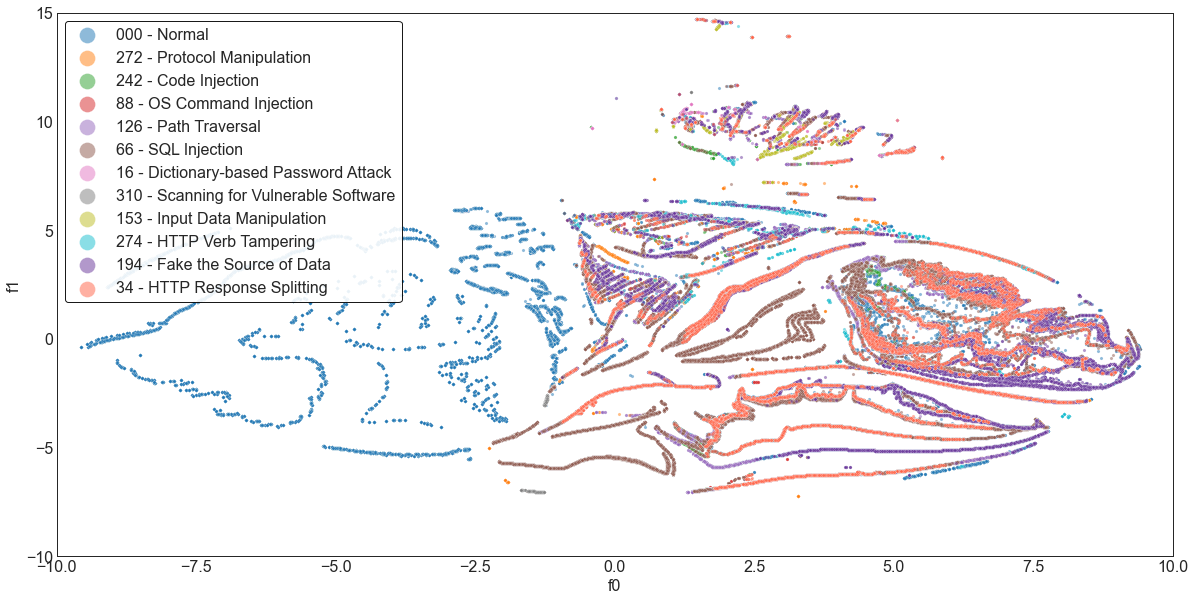

In [397]:
plt.figure(figsize=(20, 10))
for i in range(13):
    sns.scatterplot(x='f0', y='f1', data=tsne2_df[tsne2_df['multilabel']==i], alpha=0.5, s=10, label=data.columns[19:][i], color = colors[i])

plt.legend(loc='upper left', markerscale=5, facecolor='white', edgecolor='black', frameon = 1, framealpha=0.9)
plt.xlim([-10,10])
plt.ylim([-10,15])
plt.show()